## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geore' #dataset-compression
TRANSFORM = 'fft-male' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_fft_1e5geore_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geore\\fft\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


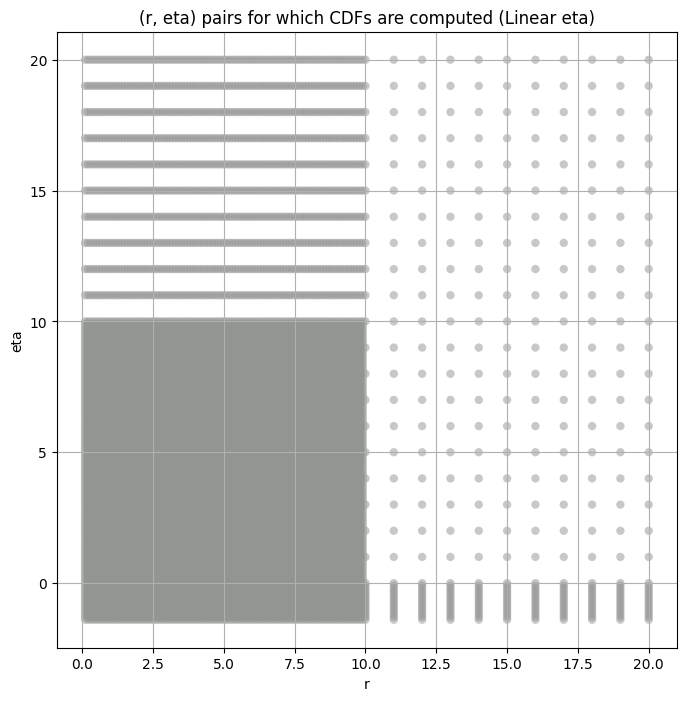

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.915643e+14  3.399509e+14  4.511006e+14   6.855218    3.785940   
5     9.777844e+14  8.494562e+14  1.116713e+15  22.652589   19.289485   
8     1.993210e+14  1.706700e+14  2.311273e+14  32.618782   23.913988   
11    1.418906e+13  1.165386e+13  1.851461e+13  86.686594   15.054620   
14    4.093398e+14  3.743596e+14  4.474916e+14  10.058353    7.365085   
17    3.880596e+14  3.658089e+14  4.122176e+14   3.375878    2.267853   
20    7.340230e+13  6.713867e+13  8.168032e+13  11.953053    5.117451   
23    1.111327e+13  1.043654e+13  1.189928e+13   4.444135    2.452249   
26    3.116548e+12  2.887243e+12  3.380704e+12   7.258533    4.206287   
30    3.558762e+10  3.261025e+10  3.898284e+10   9.742558    6.116816   

      kurt_upper  total_samples  
band                             
2       9.952542         1440.0  
5      26.255725         4320.0  
8      41.579806        12240.0  
11    257.973300        33840.0  
14     14.099301        93600.0  
17      6.326154       100000.0  
20     40.137968       100000.0  
23     12.334988       100000.0  
26     17.534173       100000.0  
30     21.662332       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     3.915643e+14   3.915643e+14    2.708500e+14    2.308373e+14   
5     9.777844e+14   9.777844e+14    6.819275e+14    5.324245e+14   
8     1.993210e+14   1.993210e+14    1.588842e+14    1.390201e+14   
11    1.418906e+13   1.418906e+13    1.160384e+13    1.084962e+13   
14    4.093398e+14   4.093398e+14    3.940137e+14    3.842871e+14   
17    3.880596e+14   3.880596e+14    3.795000e+14    3.742659e+14   
20    7.340230e+13   7.340230e+13    6.990304e+13    6.825672e+13   
23    1.111327e+13   1.111327e+13    1.081684e+13    1.065191e+13   
26    3.116548e+12   3.116548e+12    3.007386e+12    2.946468e+12   
30    3.558762e+10   3.558762e+10    3.421456e+10    3.343076e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       2.057920e+14     1.865471e+14     1.572707e+14     1.338470e+14   
5       4.369172e+14     3.726958e+14     2.902250e+14     2.377901e+14   
8       1.268711e+14     1.166028e+14     9.997960e+13     8.758098e+13   
11      1.043251e+13     1.012694e+13     9.688535e+12     9.365862e+12   
14      3.762505e+14     3.693295e+14     3.576297e+14     3.474309e+14   
17      3.698834e+14     3.660276e+14     3.592667e+14     3.532956e+14   
20      6.695337e+13     6.584325e+13     6.397377e+13     6.241239e+13   
23      1.051626e+13     1.039686e+13     1.018982e+13     1.001113e+13   
26      2.897411e+12     2.854919e+12     2.782384e+12     2.720699e+12   
30      3.278763e+10     3.222835e+10     3.126803e+10     3.044611e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.154252e+14     1.003164e+14     8.777297e+13     5.937343e+13  
5        2.002019e+14     1.734655e+14     1.535314e+14     1.157449e+14  
8        7.820122e+13     7.117150e+13     6.536123e+13     5.354386e+13  
11       9.095828e+12     8.869060e+12     8.674971e+12     8.207890e+12  
14       3.384667e+14     3.304291e+14     3.230892e+14     3.038377e+14  
17       3.478787e+14     3.429272e+14     3.383324e+14     3.261067e+14  
20       6.105480e+13     5.983640e+13     5.872574e+13     5.588430e+13  
23       9.851654e+12     9.707006e+12     9.573530e+12     9.221633e+12  
26       2.666394e+12     2.617530e+12     2.572839e+12     2.456792e+12  
30       2.971957e+10     2.906253e+10     2.846078e+10     2.689729e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01316614171841135 391564280511945.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.013726335186691085 270850004705797.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.024410918254796354 230837287107961.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.03243334504753795 205792007390359.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.042046884842439625 186547142794307.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.060357372567288126 157270721993025.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.07853569063674237 133846977847583.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.09522975670433151 115425187090846.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.11068553744171475 100316352159659.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.12491873818383481 87772969630402.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.16661967457837346 59373427893169.375
Number of samples: 2880, Without approximation : 1440.0


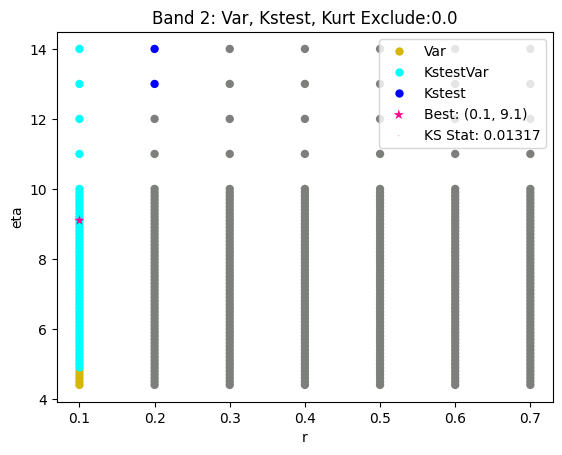

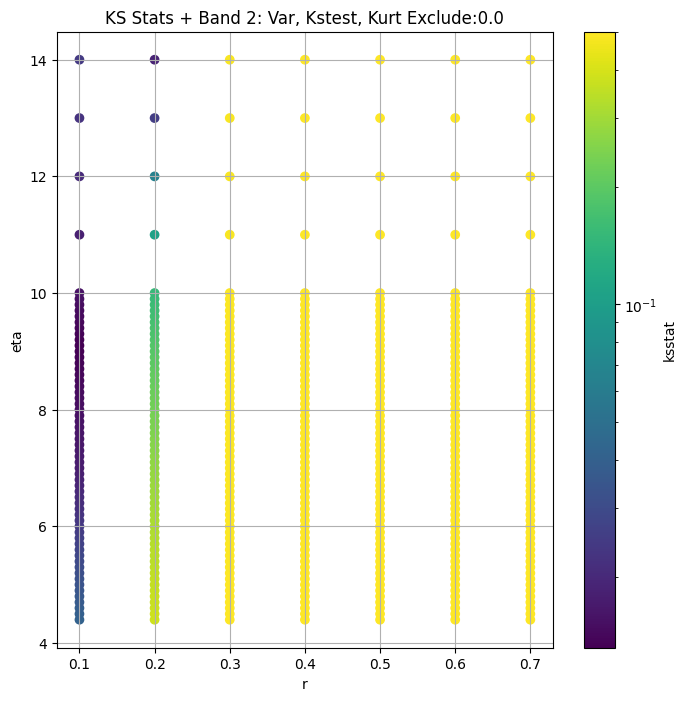

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.031306778194255744 977784425740355.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.023321339090699555 681927462028995.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.018532164994638445 532424541893435.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.014195632334779607 436917231700093.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01686578424068734 372695786532998.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.02208572247335272 290225028478517.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.027070718306861034 237790116670133.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03259123769230421 200201892014789.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0380445051827185 173465466257556.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04296200981050224 153531409561309.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.05817076185944792 115744914476319.39
Number of samples: 8640, Without approximation : 4320.0


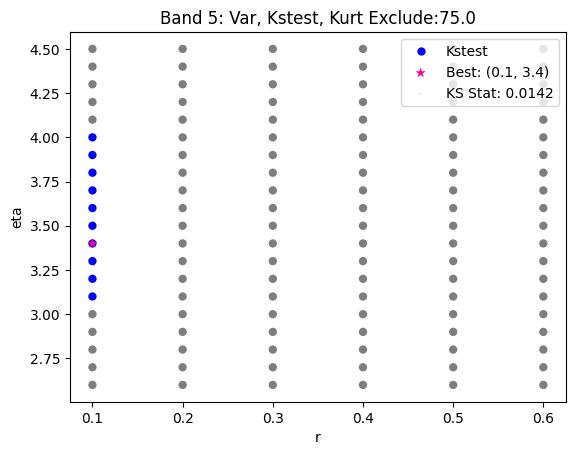

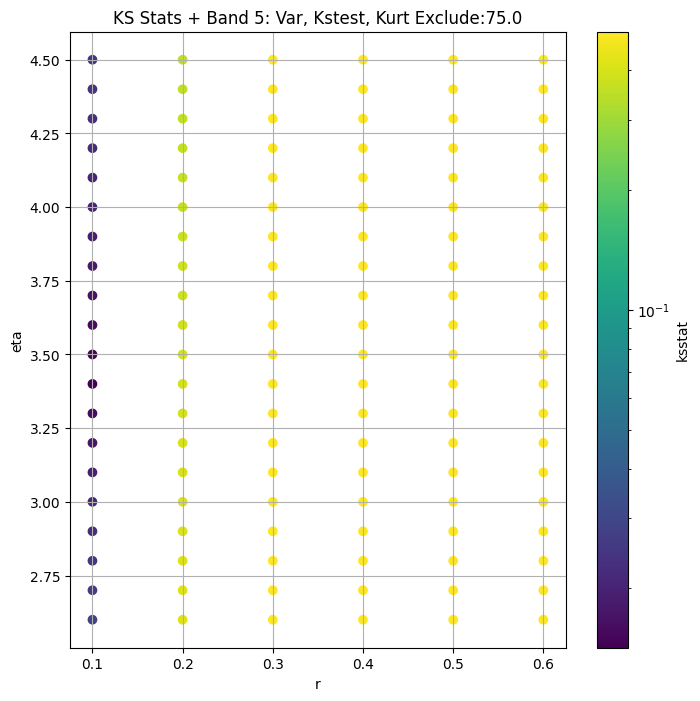

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.020485540931094278 199321010423472.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.020485540931094278 158884231740583.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.020485540931094278 139020148991011.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.019672455622708918 126871080422084.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01699223749863754 116602817518249.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.01330532976971327 99979601913425.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011817963782141727 87580980833808.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013352824807023267 78201216668577.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.015113972245552982 71171498361542.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.016811404005583785 65361226403171.234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02299333986556175 53543862850445.79
Number of samples: 24480, Without approximation : 12240.0


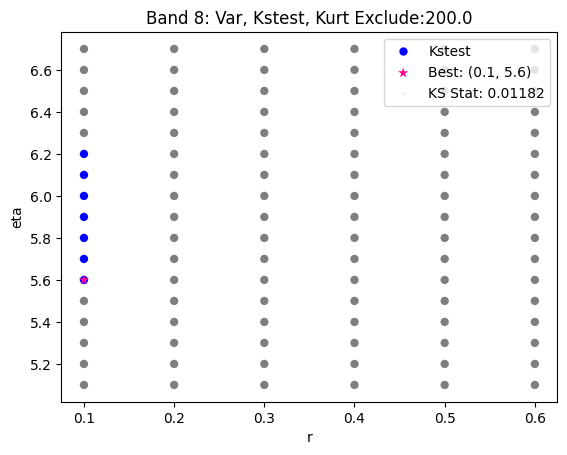

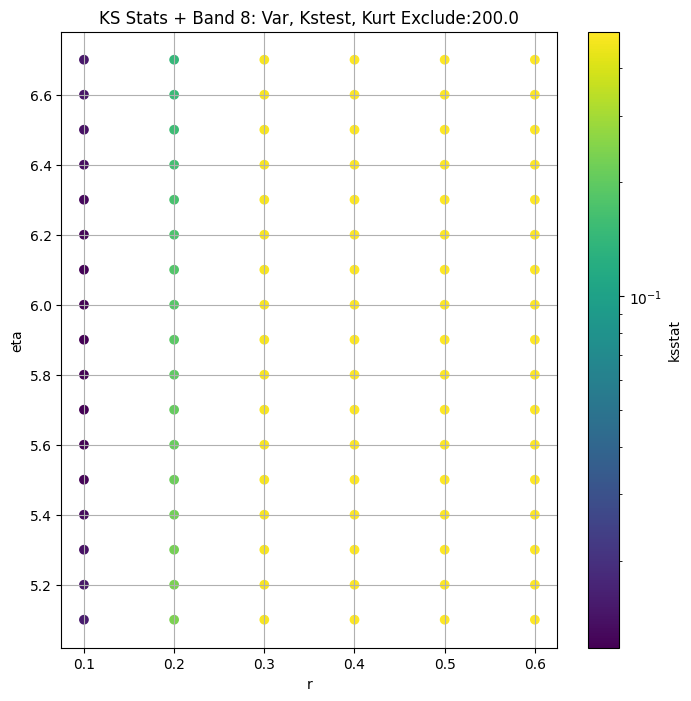

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.007956802527451123 14189059892878.807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.007956802527451123 11603836130585.092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.007956802527451123 10849623712628.727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.006449103466770072 10432514439234.496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.005473918116625676 10126936479039.402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0037032141862015297 9688535162982.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.00414594908496313 9365861633685.344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.004772828768348003 9095828176571.404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.005306006356570955 8869059669457.377


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.005768960071642698 8674970577370.164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.00894763076490191 8207890263468.158
Number of samples: 67680, Without approximation : 33840.0


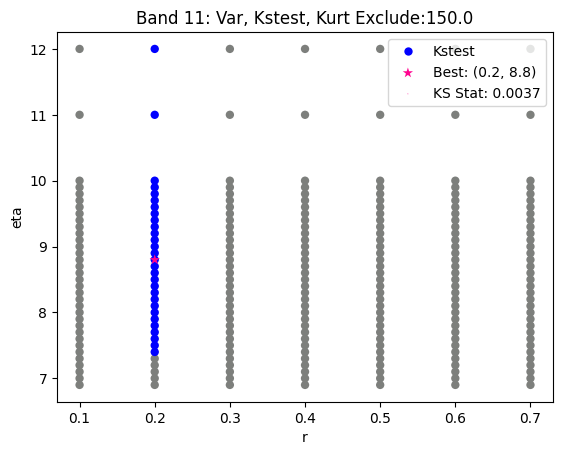

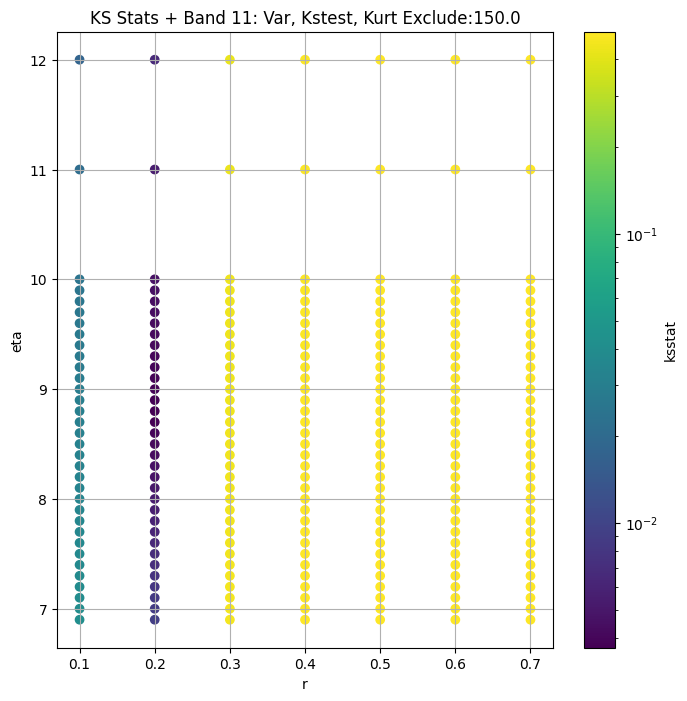

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.019083032655575025 409339796513149.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.019394076700979604 394013680196120.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.020935304791144985 384287073512369.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02035213799143132 376250533833250.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.021491720461185596 369329549741259.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.02178524310067971 357629672330023.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.02212601075019123 347430949711326.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.023548254242950914 338466677298085.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02371210993611564 330429102519035.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.023906275012581246 323089249671689.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.025781209822899442 303837733644252.44
Number of samples: 100000, Without approximation : 93600.0


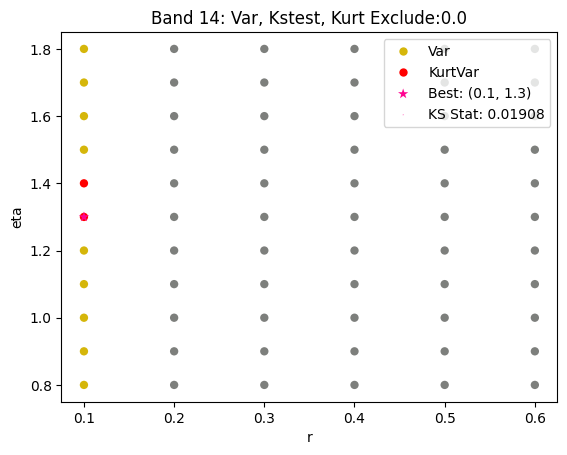

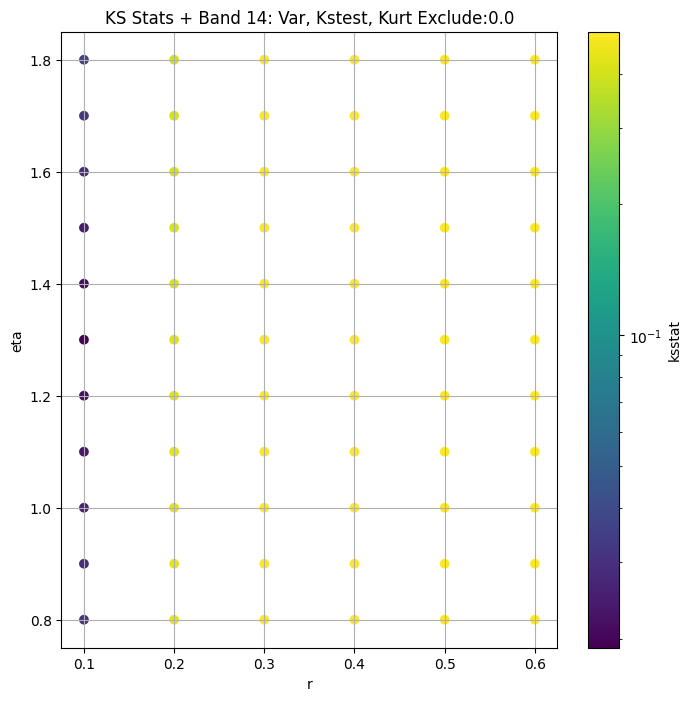

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.002357005296193204 388059590599047.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.0030005460454468613 379500034699133.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.0035116065373062832 374265911844084.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.0038842581064948423 369883418898729.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.0039053053659233172 366027571411018.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.004680874867972591 359266713108618.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.005478926247215264 353295570676544.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.006396175502509316 347878659028683.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.007332011877233022 342927191110078.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.008499291273326909 338332424792540.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.011853015200593994 326106662273395.7
Number of samples: 100000, Without approximation : 100000.0


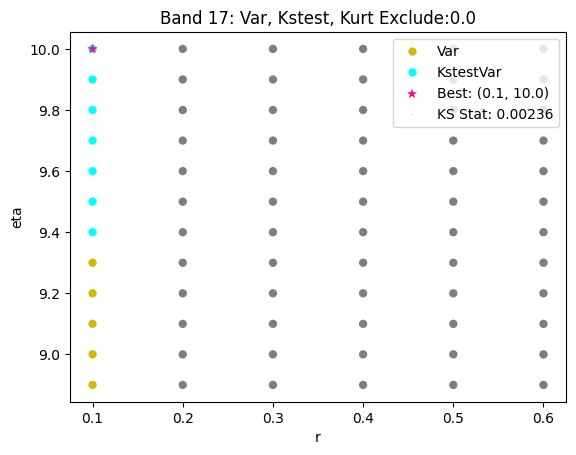

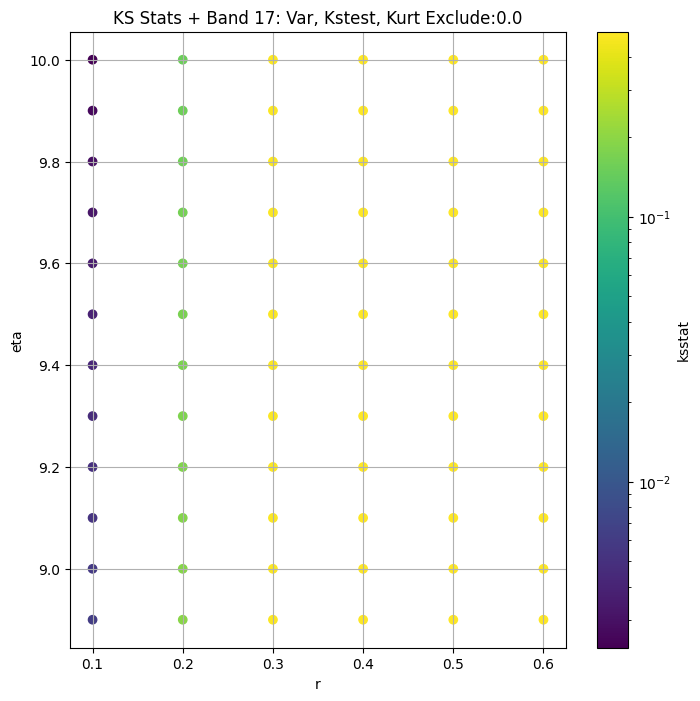

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.005611628354620035 73402296007671.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.004103048910622631 69903039606038.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.003432771079407315 68256723341686.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0027797921632558564 66953369894790.445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.002341598420456781 65843249137280.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0030041316180797716 63973773445742.01


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.0037260507918280214 62412385146510.414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.00443876066446337 61054796941724.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.005254235520887673 59836400326359.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006029793732666131 58725736037362.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.00813816383648163 55884299182035.49
Number of samples: 100000, Without approximation : 100000.0


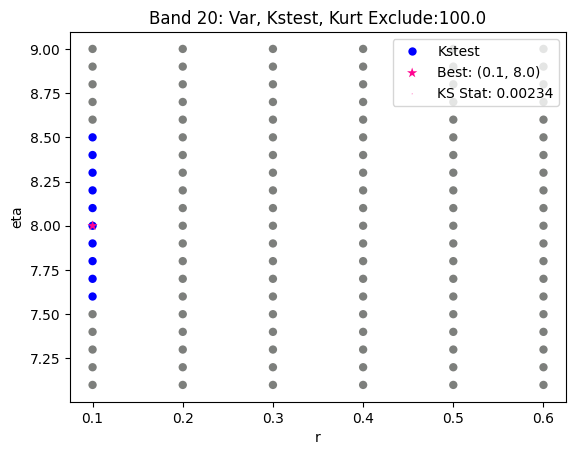

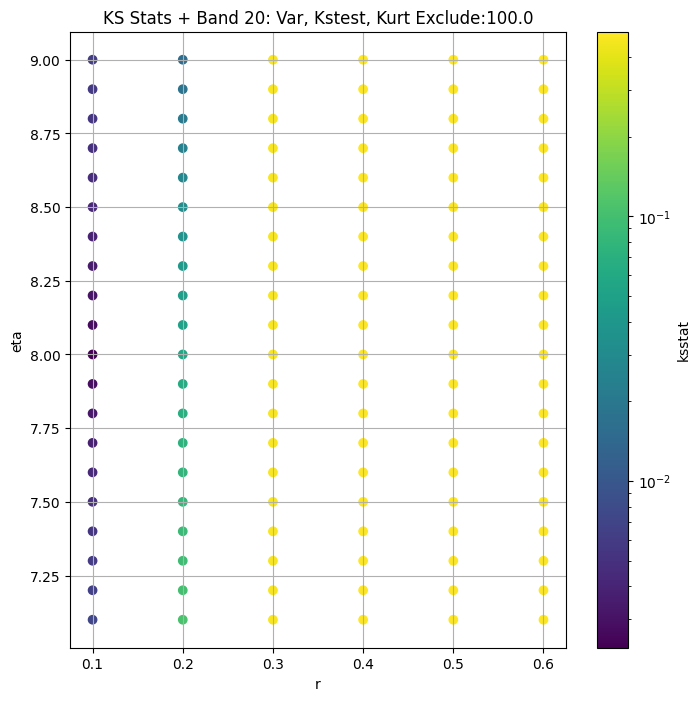

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0016579641038522164 11113272943886.115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0007926678836374657 10816841391684.566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.001209101828091903 10651911027547.852


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0016328698869444054 10516259454459.559


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0020808675057133984 10396858006868.023


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0029076473513493586 10189820385489.984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0037974234215047073 10011126973081.234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.0046252289042622435 9851653590447.783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005402323485474911 9707005926424.135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.0061508629849877025 9573530368490.404


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.00827017539149296 9221633131699.525
Number of samples: 100000, Without approximation : 100000.0


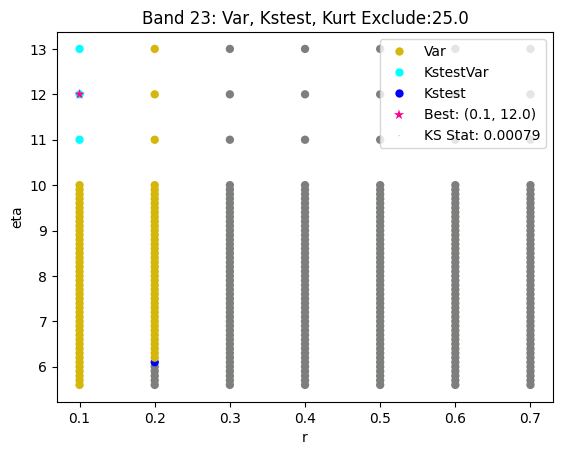

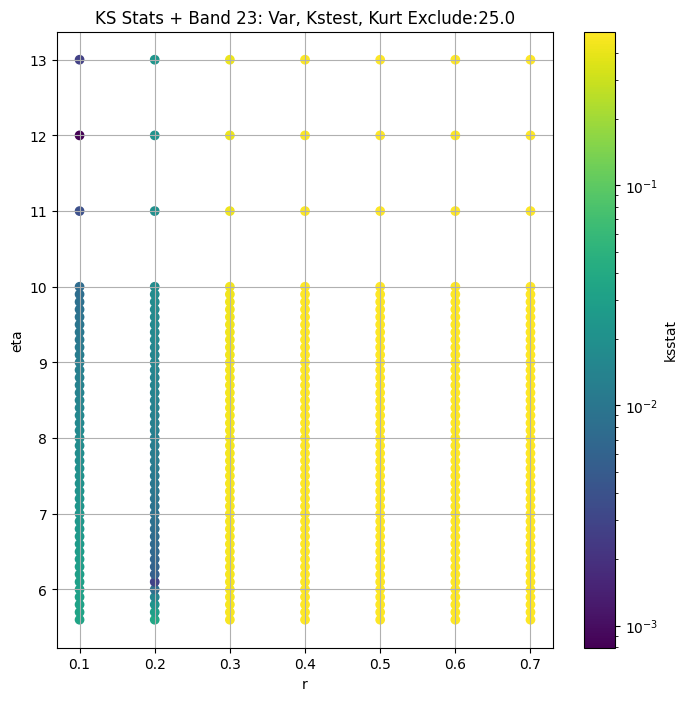

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0006839916525872569 3116547597425.8037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0010094531493925474 3007385857292.491


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.001724720578938764 2946467701593.0835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0023928533392866894 2897411202239.497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.002976984925090423 2854918507905.4673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.004001652635858631 2782383628688.4937


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004953417062357746 2720699309648.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005799612361148211 2666393978908.2617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006532006458049633 2617530362378.9224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006993772367571857 2572839153300.96


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.00918913736219177 2456792202231.224
Number of samples: 100000, Without approximation : 100000.0


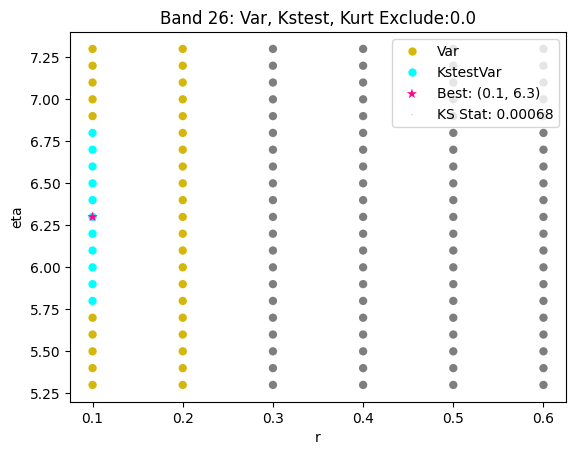

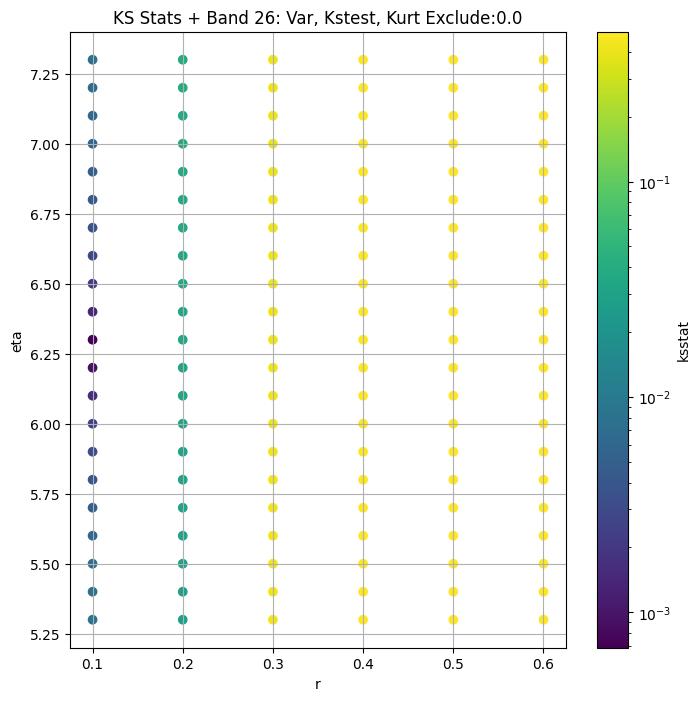

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.002249798712268651 35587624748.89857


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.00331695724748899 34214559962.10997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0031689852503359803 33430761332.10104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.003712273254401016 32787634823.829716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.0041918627149777 32228347409.49106


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.005280852735390834 31268033056.01594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.0062352963946486 30446114515.085293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.006938784199766457 29719566808.235367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.007759793861506048 29062527749.533188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.008542548354854573 28460784673.141388


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.010611341976539346 26897288669.18042
Number of samples: 100000, Without approximation : 100000.0


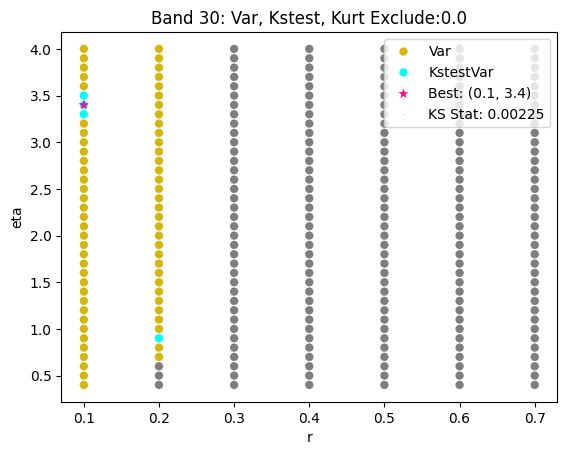

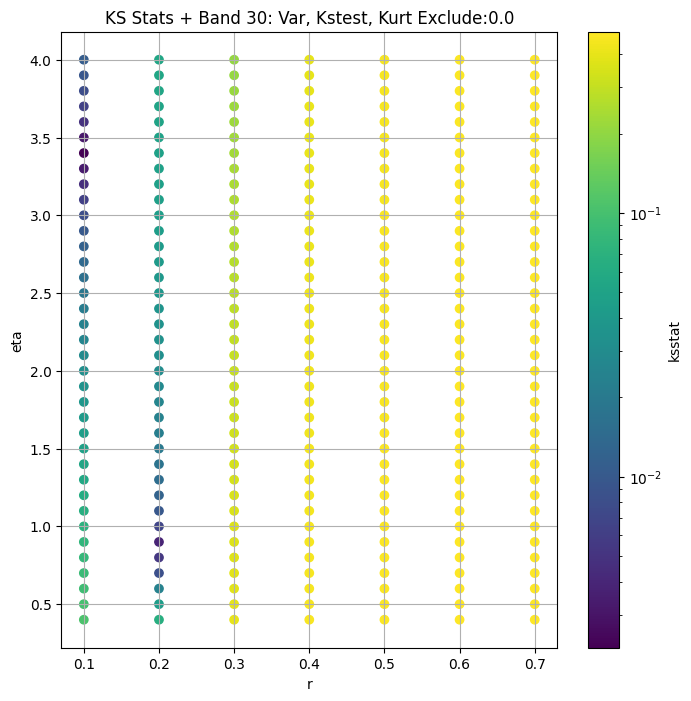

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.915643e+14  3.399509e+14  4.511006e+14   6.855218    3.785940   
5     9.777844e+14  8.494562e+14  1.116713e+15  22.652589   19.289485   
8     1.993210e+14  1.706700e+14  2.311273e+14  32.618782   23.913988   
11    1.418906e+13  1.165386e+13  1.851461e+13  86.686594   15.054620   
14    4.093398e+14  3.743596e+14  4.474916e+14  10.058353    7.365085   
17    3.880596e+14  3.658089e+14  4.122176e+14   3.375878    2.267853   
20    7.340230e+13  6.713867e+13  8.168032e+13  11.953053    5.117451   
23    1.111327e+13  1.043654e+13  1.189928e+13   4.444135    2.452249   
26    3.116548e+12  2.887243e+12  3.380704e+12   7.258533    4.206287   
30    3.558762e+10  3.261025e+10  3.898284e+10   9.742558    6.116816   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       9.952542         1440.0             0.013166        0.1          9.1   
5      26.255725         4320.0             0.014196        0.1          3.4   
8      41.579806        12240.0             0.011818        0.1          5.6   
11    257.973300        33840.0             0.003703        0.2          8.8   
14     14.099301        93600.0             0.019083        0.1          1.3   
17      6.326154       100000.0             0.002357        0.1         10.0   
20     40.137968       100000.0             0.002342        0.1          8.0   
23     12.334988       100000.0             0.000793        0.1         12.0   
26     17.534173       100000.0             0.000684        0.1          6.3   
30     21.662332       100000.0             0.002250        0.1          3.4   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.447599e-06                     0.0        3.915643e+14   
5      2.307472e-03                    75.0        4.369172e+14   
8      1.465842e-05                   200.0        8.758098e+13   
11     2.214360e+04                   150.0        9.688535e+12   
14     3.238395e-01                     0.0        4.093398e+14   
17     6.553518e-07                     0.0        3.880596e+14   
20     6.951704e-07                   100.0        6.584325e+13   
23     3.884001e-09                    25.0        1.081684e+13   
26     2.146689e-07                     0.0        3.116548e+12   
30     1.879473e-07                     0.0        3.558762e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.035671  
5                    0.020624  
8                    0.012262  
11                   0.007378  
14                   0.004437  
17                   0.004293  
20                   0.004293  
23                   0.004293  
26                   0.004293  
30                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.05397470180977634, var: 186547142794307.78


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.04348002701184017, var: 205792007390359.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.03240065508771153, var: 230837287107961.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.016415277391993777, var: 270850004705797.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.01316614171841135, var: 391564280511945.6
Number of samples: 2880, Without approximation : 1440.0


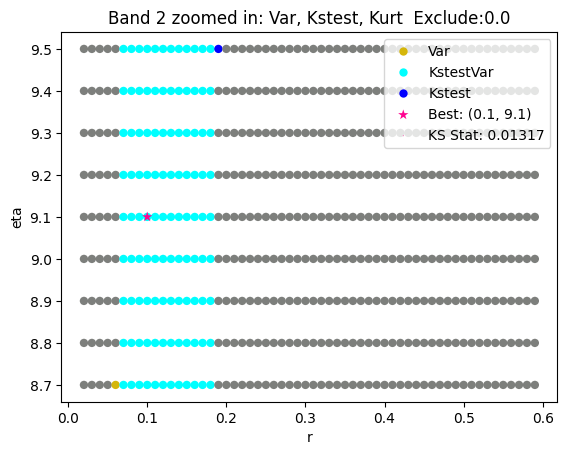

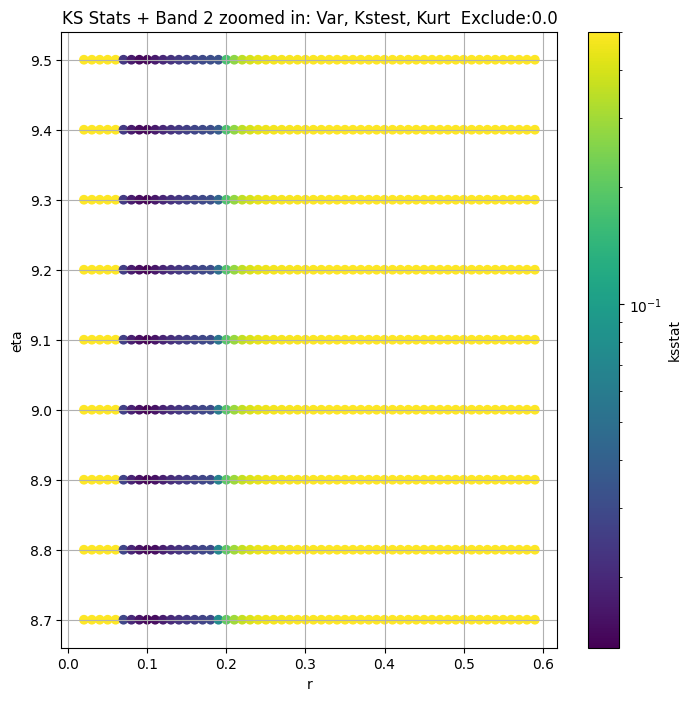

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.024598291279469938, var: 261696172313069.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.02202522560439435, var: 290225028478517.7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.019621975316368445, var: 325028090748009.9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.01684141316258228, var: 372695786532998.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.014195632334779607, var: 436917231700093.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.01779616432906128, var: 532424541893435.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.02059787465591144, var: 681927462028995.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.02059787465591144, var: 977784425740355.0
Number of samples: 8640, Without approximation : 4320.0


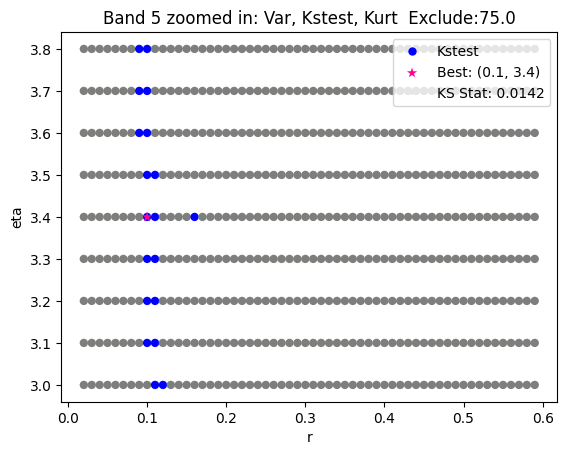

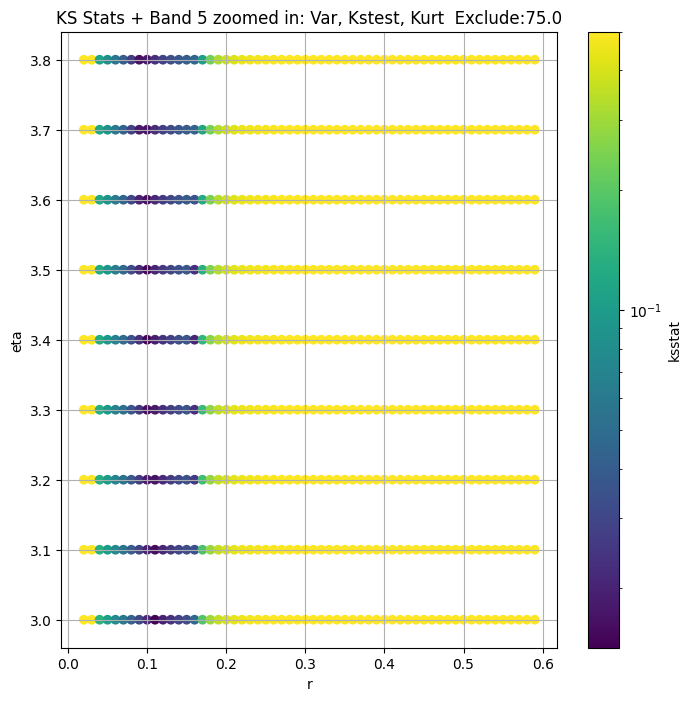

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 100 = 300, ksstat: 0.015111884227458435, var: 71171498361542.12


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 75 = 275, ksstat: 0.01423861203615373, var: 74524230809910.5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 50 = 250, ksstat: 0.013334347351505405, var: 78201216668577.48


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 25 = 225, ksstat: 0.012643051573485678, var: 82561277188040.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + 0 = 200, ksstat: 0.011817963782141727, var: 87580980833808.77


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -25 = 175, ksstat: 0.011462536901186815, var: 93371223405054.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -50 = 150, ksstat: 0.013111554090666333, var: 99979601913425.66


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -75 = 125, ksstat: 0.01491867352166576, var: 107702693631042.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 200.0 + -100 = 100, ksstat: 0.0157462532918289, var: 116602817518249.67
Number of samples: 24480, Without approximation : 12240.0


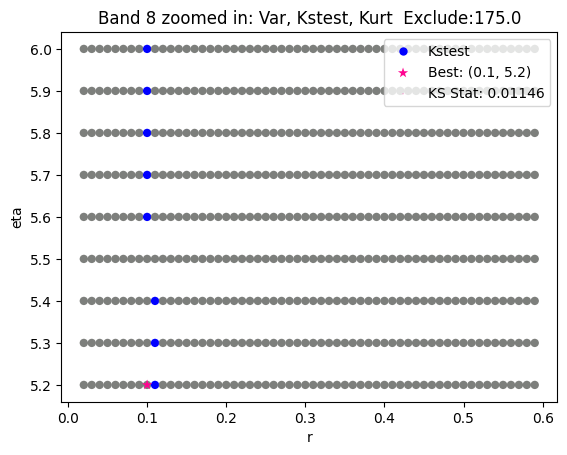

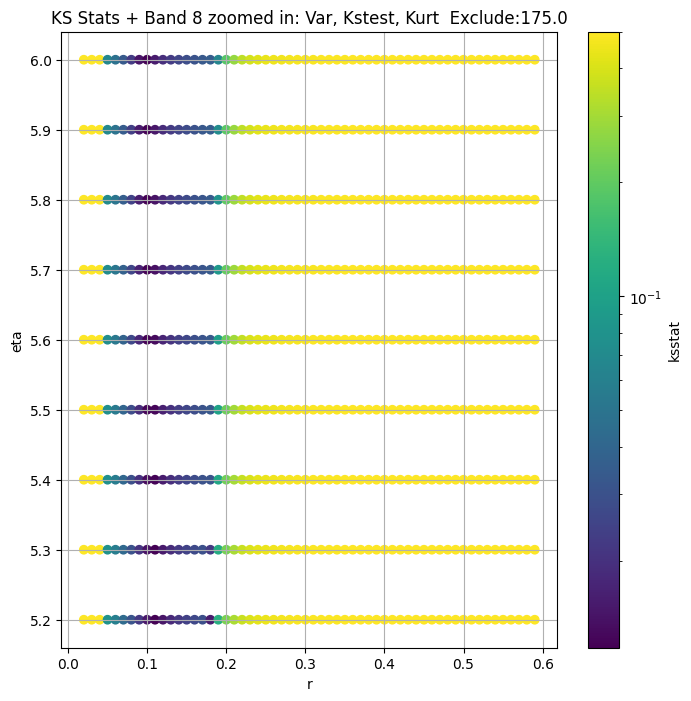

Band 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.0066098542220972, var: 9095828176571.404


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.005222968891355262, var: 9225305015580.137


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.004157175761603349, var: 9365861633685.344


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.003936961950285367, var: 9519497132948.756


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.0037032141862015297, var: 9688535162982.89


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.004387053613291503, var: 9885760964167.197


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.005273791161449992, var: 10126936479039.402


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.006533524093285455, var: 10432514439234.496


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.008212936181813901, var: 10849623712628.727
Number of samples: 67680, Without approximation : 33840.0


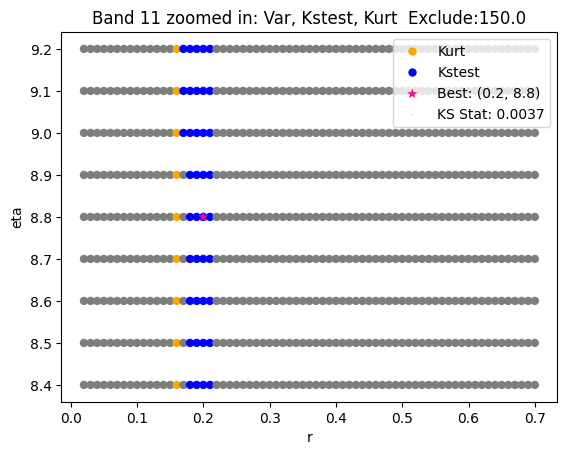

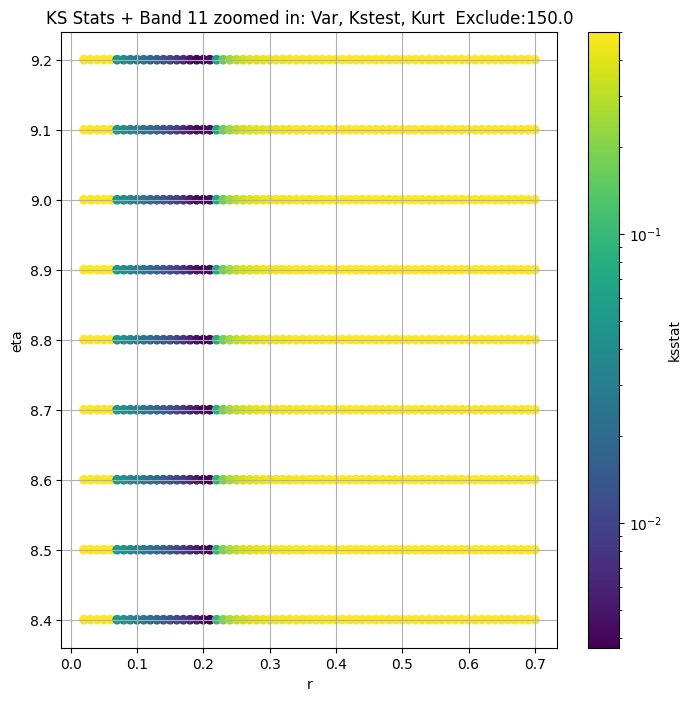

Band 14


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.020084801600060473, var: 369329549741259.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.020107640329571935, var: 376250533833250.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.01971147934563651, var: 384287073512369.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.01912791476930431, var: 394013680196120.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.019083032655575025, var: 409339796513149.94
Number of samples: 100000, Without approximation : 93600.0


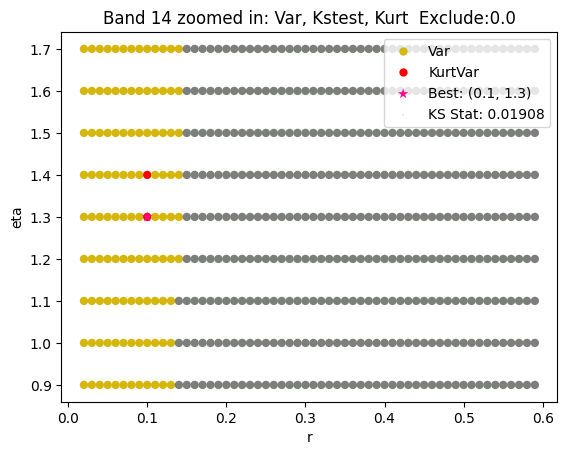

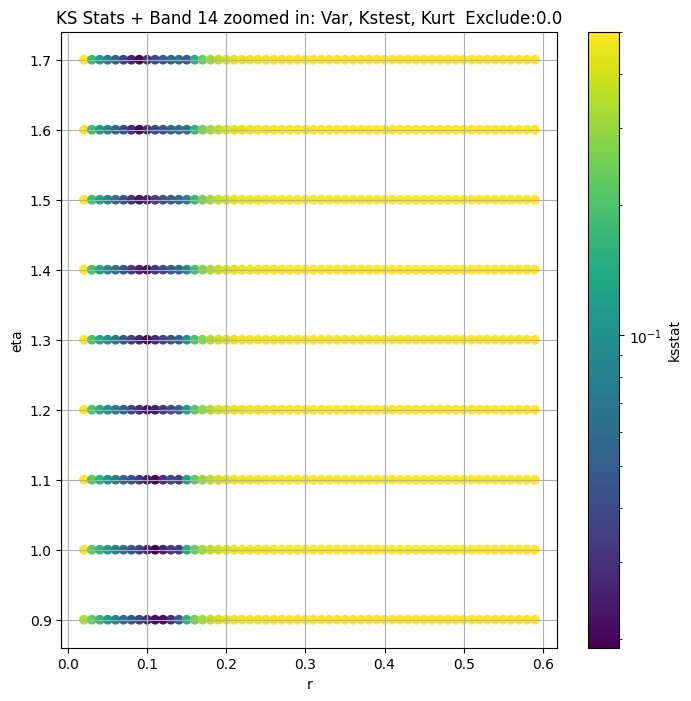

Band 17


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.003688038238282426, var: 366027571411018.9


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.0035081951275054424, var: 369883418898729.4


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.0031506726523897882, var: 374265911844084.06


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.0025814540608187775, var: 379500034699133.7


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.002357005296193204, var: 388059590599047.7
Number of samples: 100000, Without approximation : 100000.0


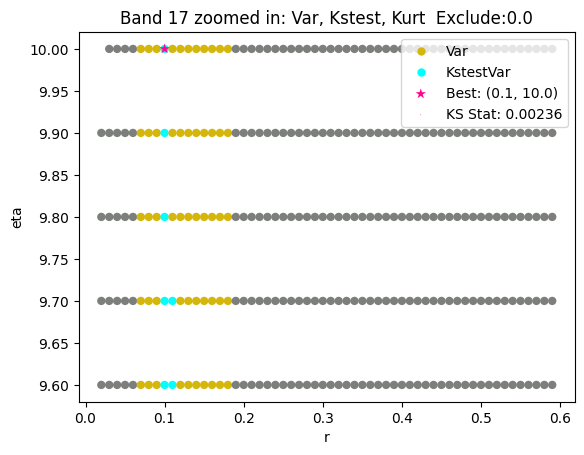

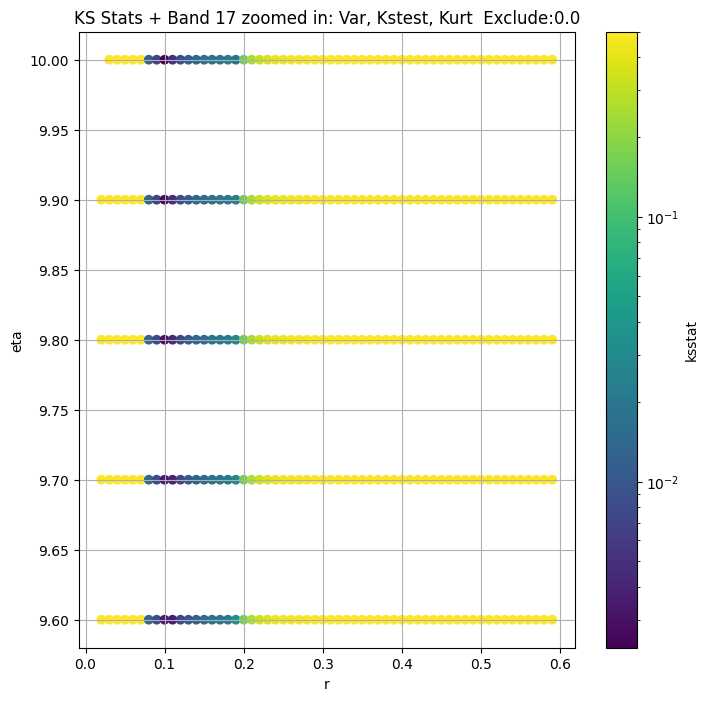

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 100 = 200, ksstat: 0.003721177124184169, var: 62412385146510.414


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 75 = 175, ksstat: 0.00337397829686387, var: 63161733006417.836


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 50 = 150, ksstat: 0.0030041316180797716, var: 63973773445742.01


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 25 = 125, ksstat: 0.0026760013373840243, var: 64861533298293.52


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 0 = 100, ksstat: 0.002341598420456781, var: 65843249137280.73


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -25 = 75, ksstat: 0.0027797921632558564, var: 66953369894790.445


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -50 = 50, ksstat: 0.0032816611784454164, var: 68256723341686.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -75 = 25, ksstat: 0.0039928094336659226, var: 69903039606038.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -100 = 0, ksstat: 0.0053413897957367285, var: 73402296007671.31
Number of samples: 100000, Without approximation : 100000.0


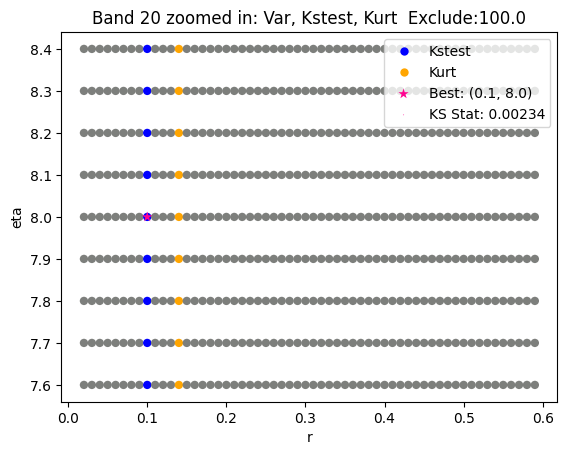

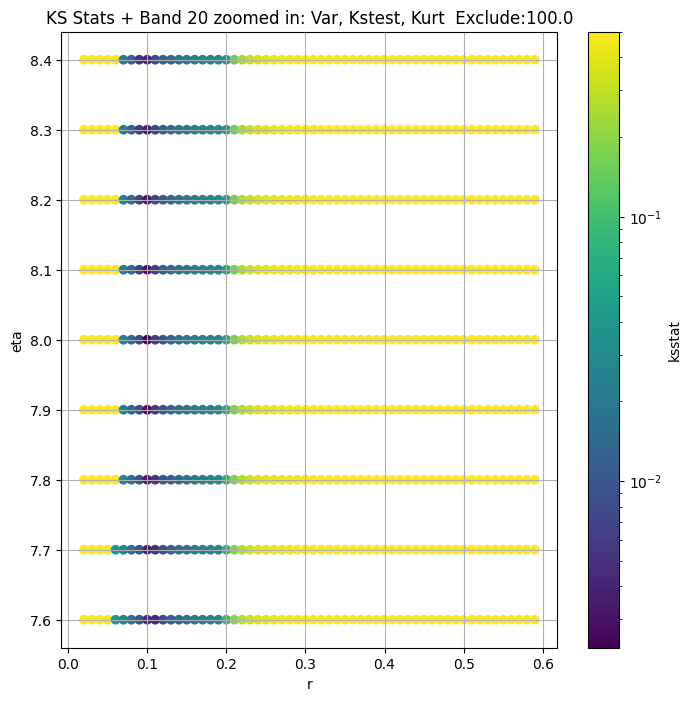

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.0026383455120817315, var: 10288914181544.086


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.002121718902450463, var: 10396858006868.023


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0016644270182416439, var: 10516259454459.559


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.002001735787084513, var: 10651911027547.852


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0007926678836374657, var: 10816841391684.566


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0028303867687925477, var: 11113272943886.115
Number of samples: 100000, Without approximation : 100000.0


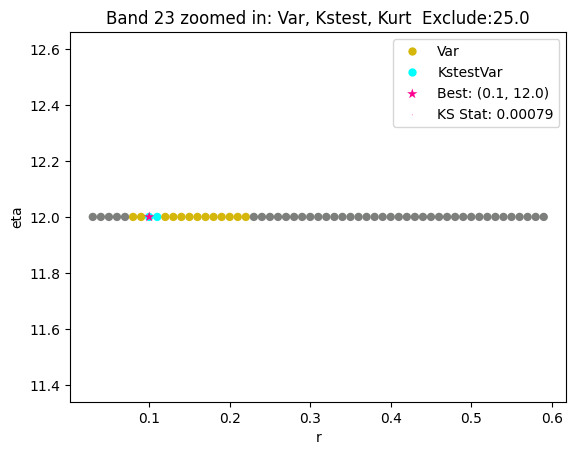

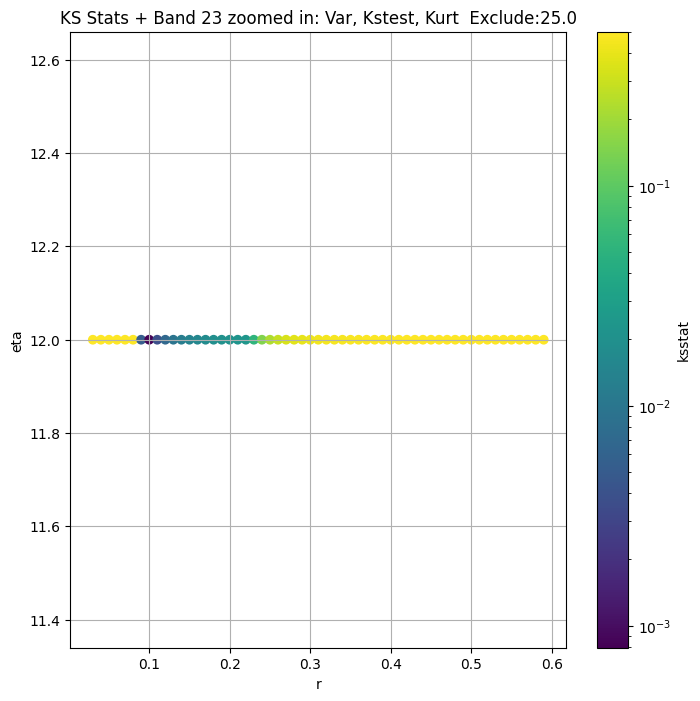

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.0028691757840830015, var: 2854918507905.4673


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.0022365399561924057, var: 2897411202239.497


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0016482834768646454, var: 2946467701593.0835


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0008786168795458238, var: 3007385857292.491


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0006839916525872569, var: 3116547597425.8037
Number of samples: 100000, Without approximation : 100000.0


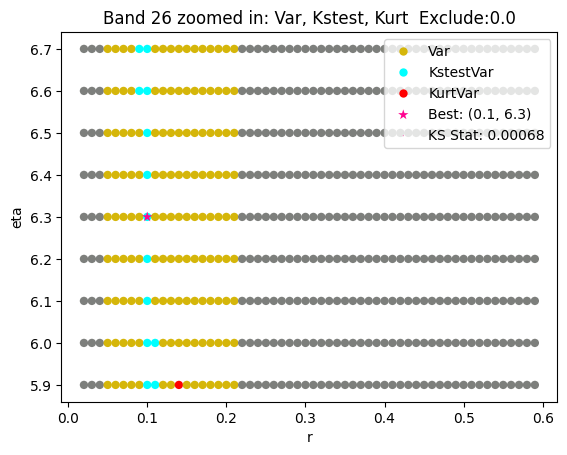

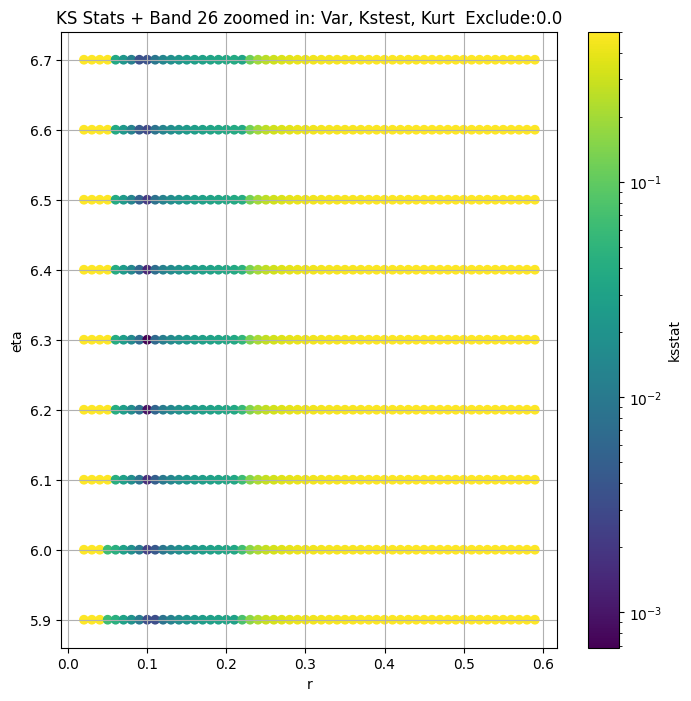

Band 30


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 100 = 100, ksstat: 0.005071223829380675, var: 32228347409.49106


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 75 = 75, ksstat: 0.004488438270940413, var: 32787634823.829716


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 50 = 50, ksstat: 0.004018747990120142, var: 33430761332.10104


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 25 = 25, ksstat: 0.003205395298372035, var: 34214559962.10997


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 30, 0.0 + 0 = 0, ksstat: 0.002249798712268651, var: 35587624748.89857
Number of samples: 100000, Without approximation : 100000.0


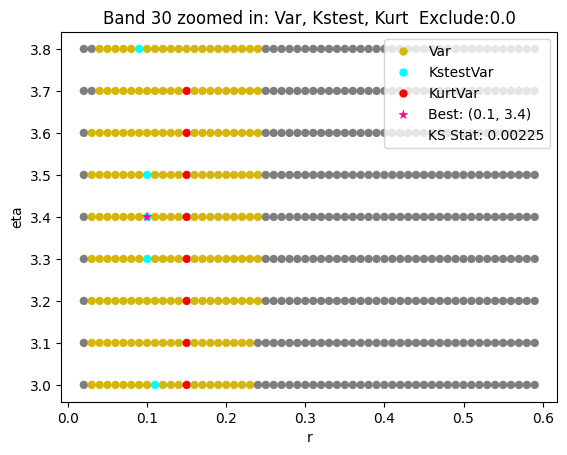

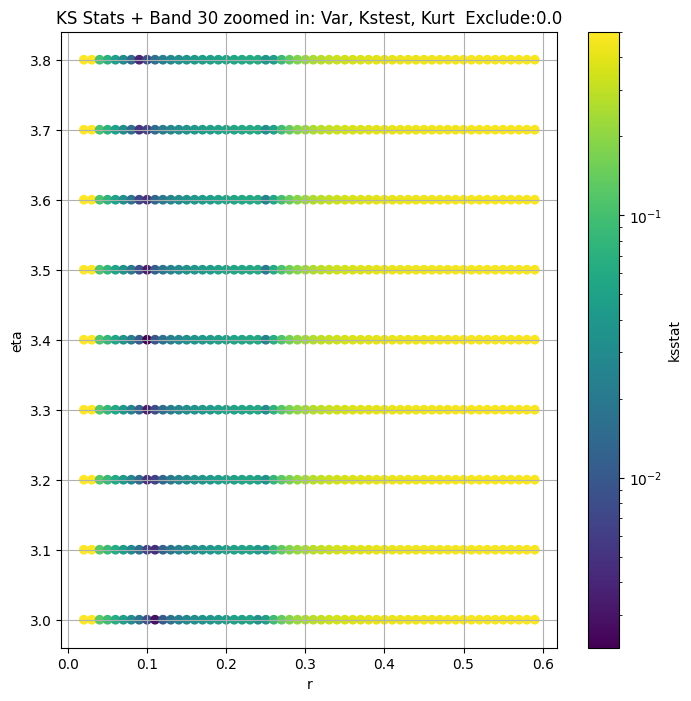

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.915643e+14  3.399509e+14  4.511006e+14   6.855218    3.785940   
5     9.777844e+14  8.494562e+14  1.116713e+15  22.652589   19.289485   
8     1.993210e+14  1.706700e+14  2.311273e+14  32.618782   23.913988   
11    1.418906e+13  1.165386e+13  1.851461e+13  86.686594   15.054620   
14    4.093398e+14  3.743596e+14  4.474916e+14  10.058353    7.365085   
17    3.880596e+14  3.658089e+14  4.122176e+14   3.375878    2.267853   
20    7.340230e+13  6.713867e+13  8.168032e+13  11.953053    5.117451   
23    1.111327e+13  1.043654e+13  1.189928e+13   4.444135    2.452249   
26    3.116548e+12  2.887243e+12  3.380704e+12   7.258533    4.206287   
30    3.558762e+10  3.261025e+10  3.898284e+10   9.742558    6.116816   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       9.952542         1440.0             0.013166        0.1          9.1   
5      26.255725         4320.0             0.014196        0.1          3.4   
8      41.579806        12240.0             0.011818        0.1          5.6   
11    257.973300        33840.0             0.003703        0.2          8.8   
14     14.099301        93600.0             0.019083        0.1          1.3   
17      6.326154       100000.0             0.002357        0.1         10.0   
20     40.137968       100000.0             0.002342        0.1          8.0   
23     12.334988       100000.0             0.000793        0.1         12.0   
26     17.534173       100000.0             0.000684        0.1          6.3   
30     21.662332       100000.0             0.002250        0.1          3.4   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.447599e-06                     0.0        3.915643e+14   
5      2.307472e-03                    75.0        4.369172e+14   
8      1.465842e-05                   200.0        9.337122e+13   
11     2.214360e+04                   150.0        9.688535e+12   
14     3.238395e-01                     0.0        4.093398e+14   
17     6.553518e-07                     0.0        3.880596e+14   
20     6.951704e-07                   100.0        6.584325e+13   
23     3.884001e-09                    25.0        1.081684e+13   
26     2.146689e-07                     0.0        3.116548e+12   
30     1.879473e-07                     0.0        3.558762e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.035671          0.013166     0.1       9.1   
5                    0.020624          0.014196     0.1       3.4   
8                    0.012262          0.011463     0.1       5.2   
11                   0.007378          0.003703     0.2       8.8   
14                   0.004437          0.019083     0.1       1.3   
17                   0.004293          0.002357     0.1      10.0   
20                   0.004293          0.002342     0.1       8.0   
23                   0.004293          0.000793     0.1      12.0   
26                   0.004293          0.000684     0.1       6.3   
30                   0.004293          0.002250     0.1       3.4   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     1.447599e-06                  0.0        10935  
5     2.307472e-03                 75.0         9225  
8     2.695640e-05                175.0        13770  
11    2.214360e+04                150.0       128485  
14    3.238395e-01                  0.0         4935  
17    6.553518e-07                  0.0       337500  
20    6.951704e-07                100.0       337500  
23    3.884001e-09                 25.0     

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

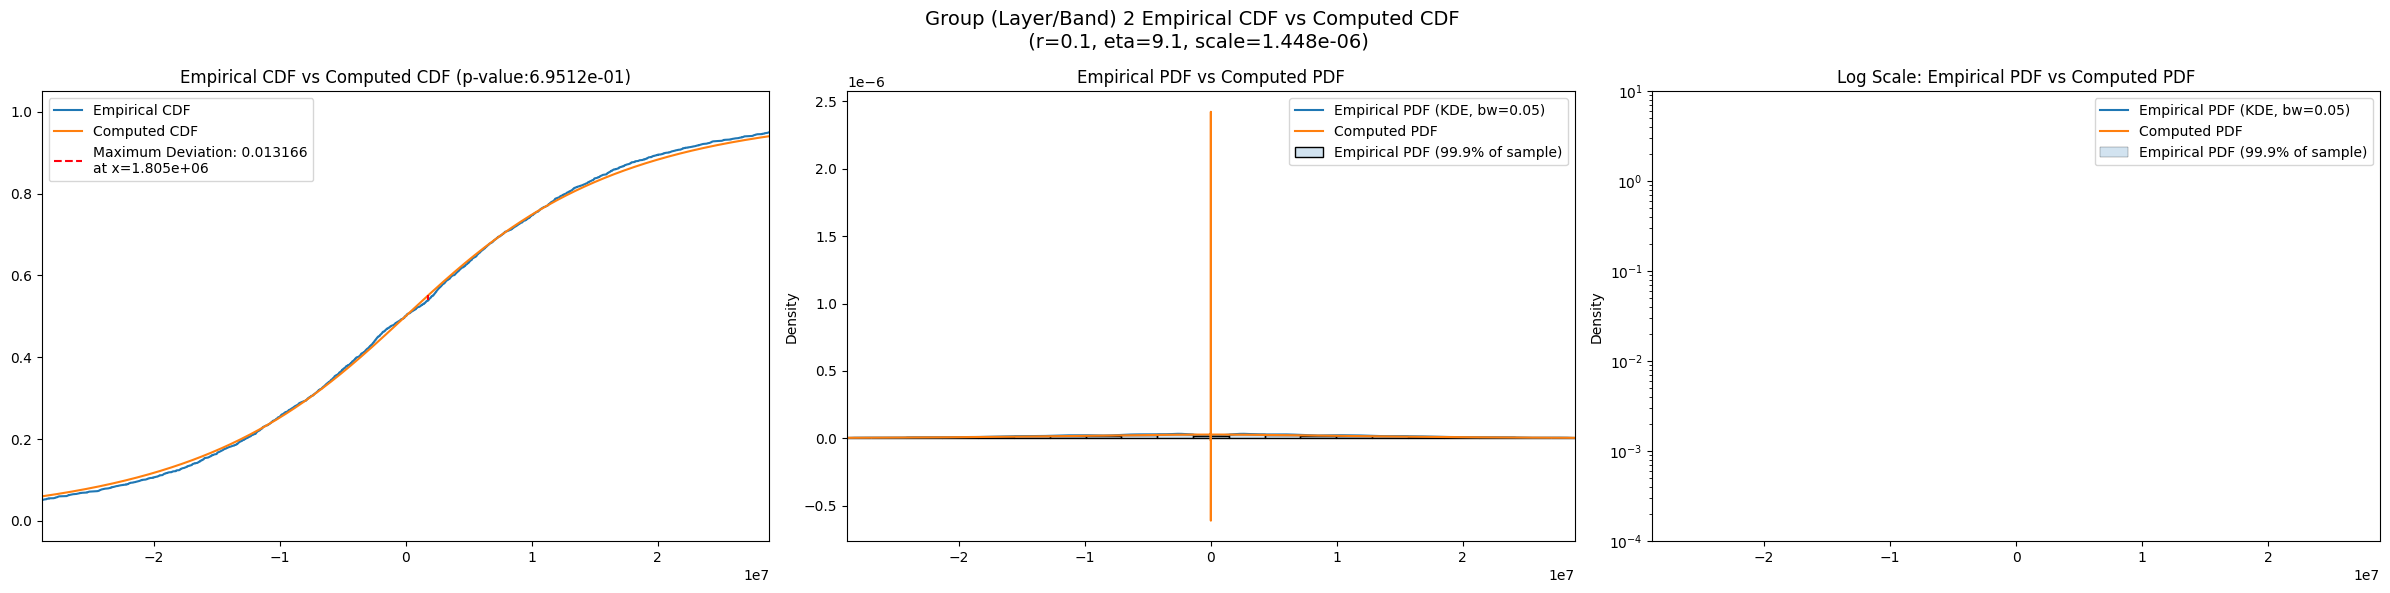

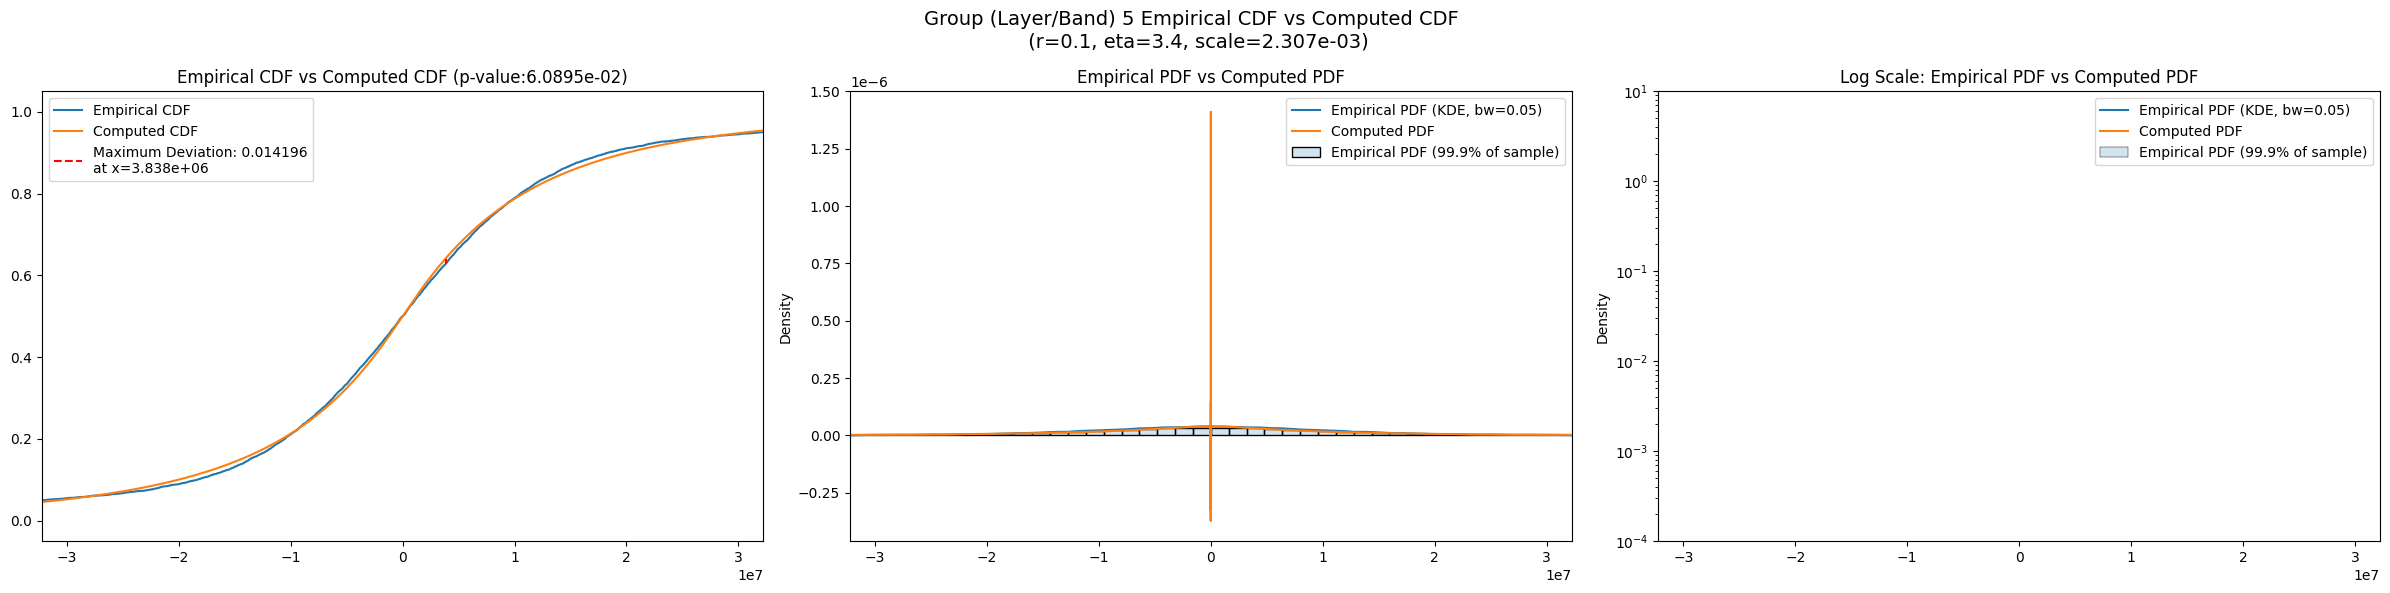

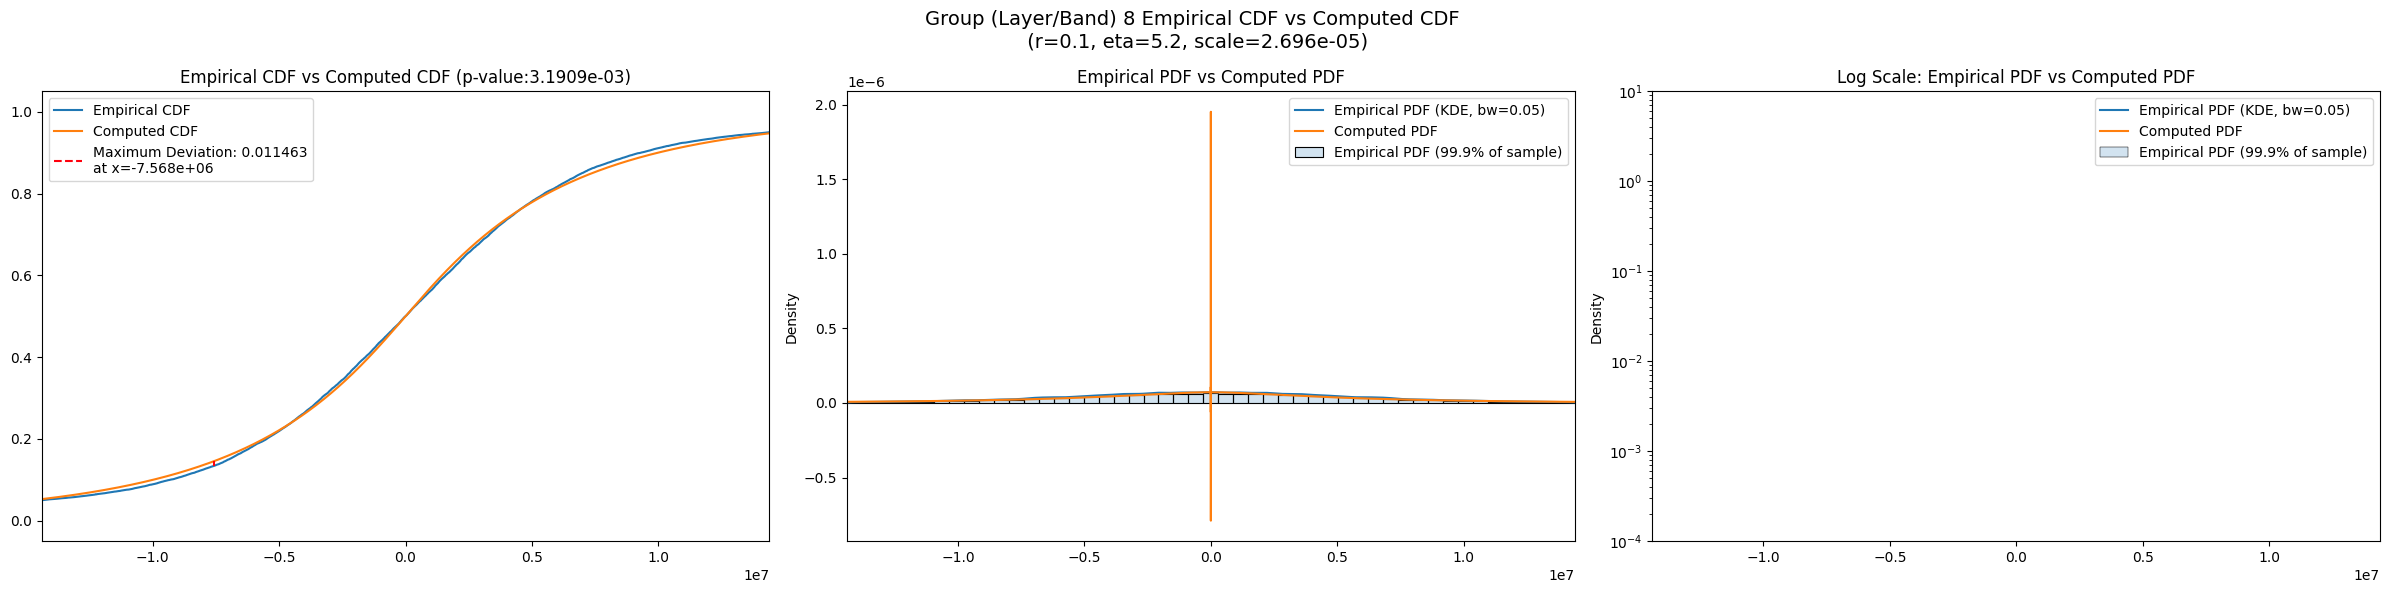

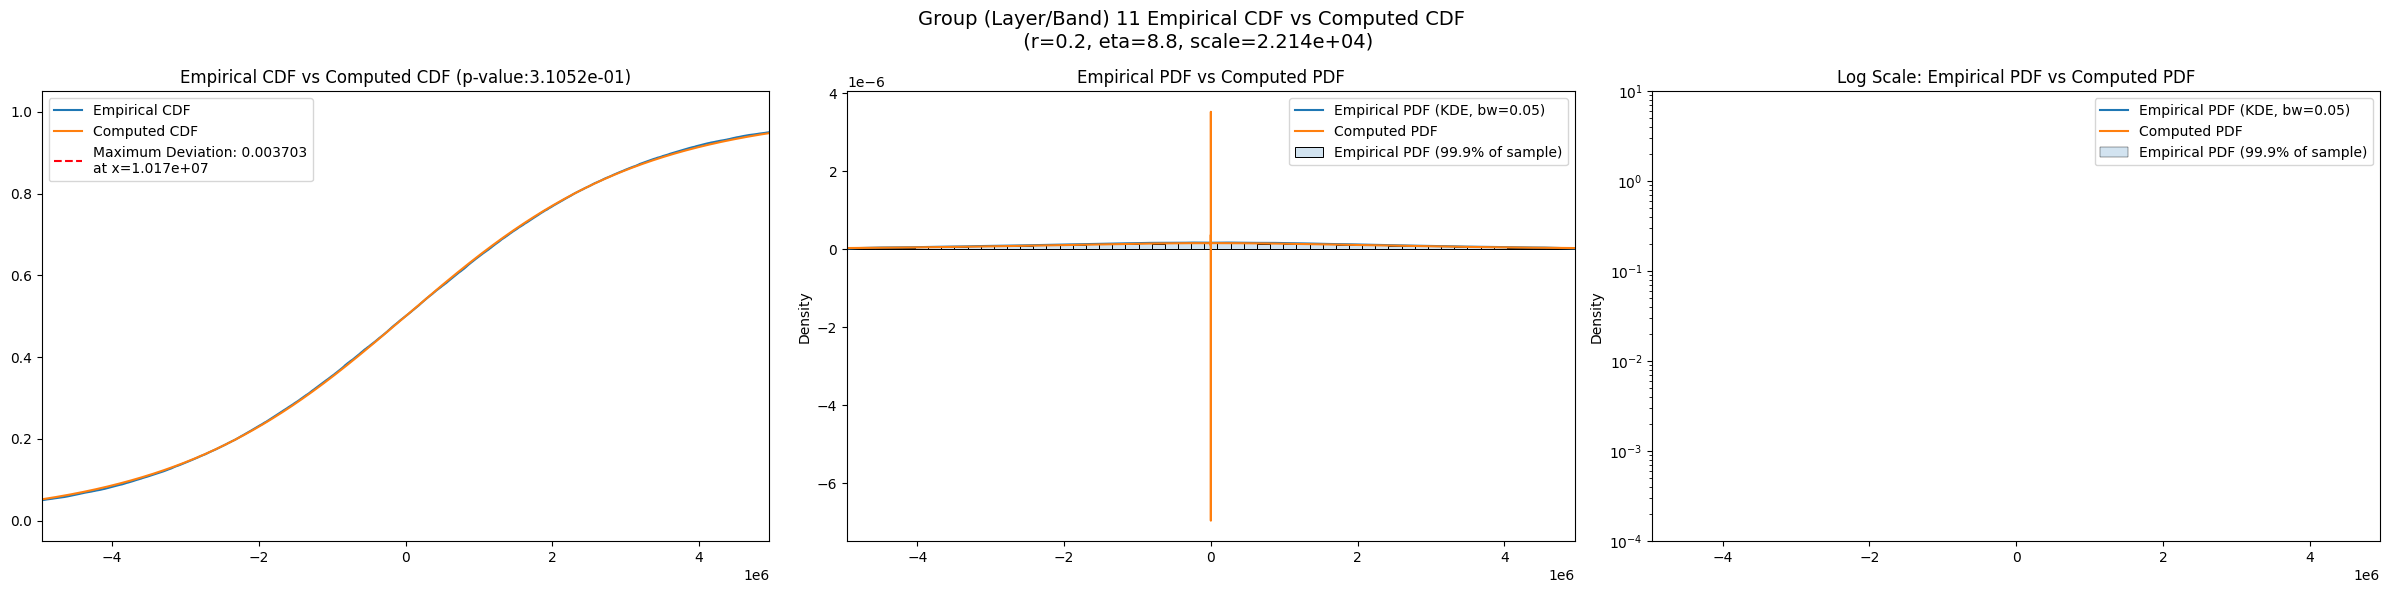

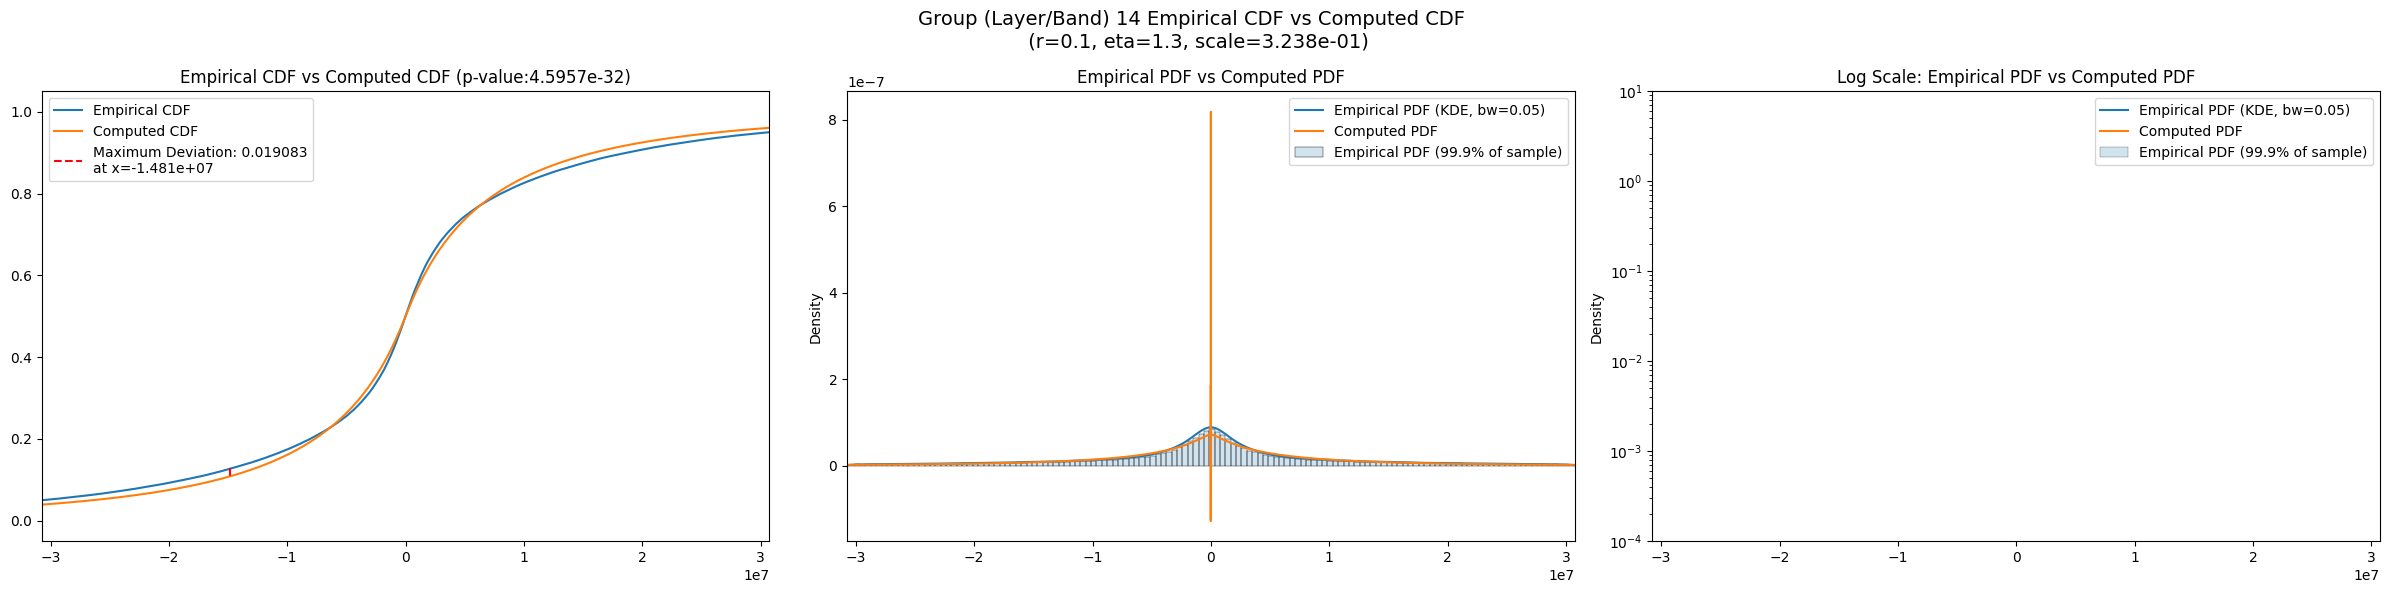

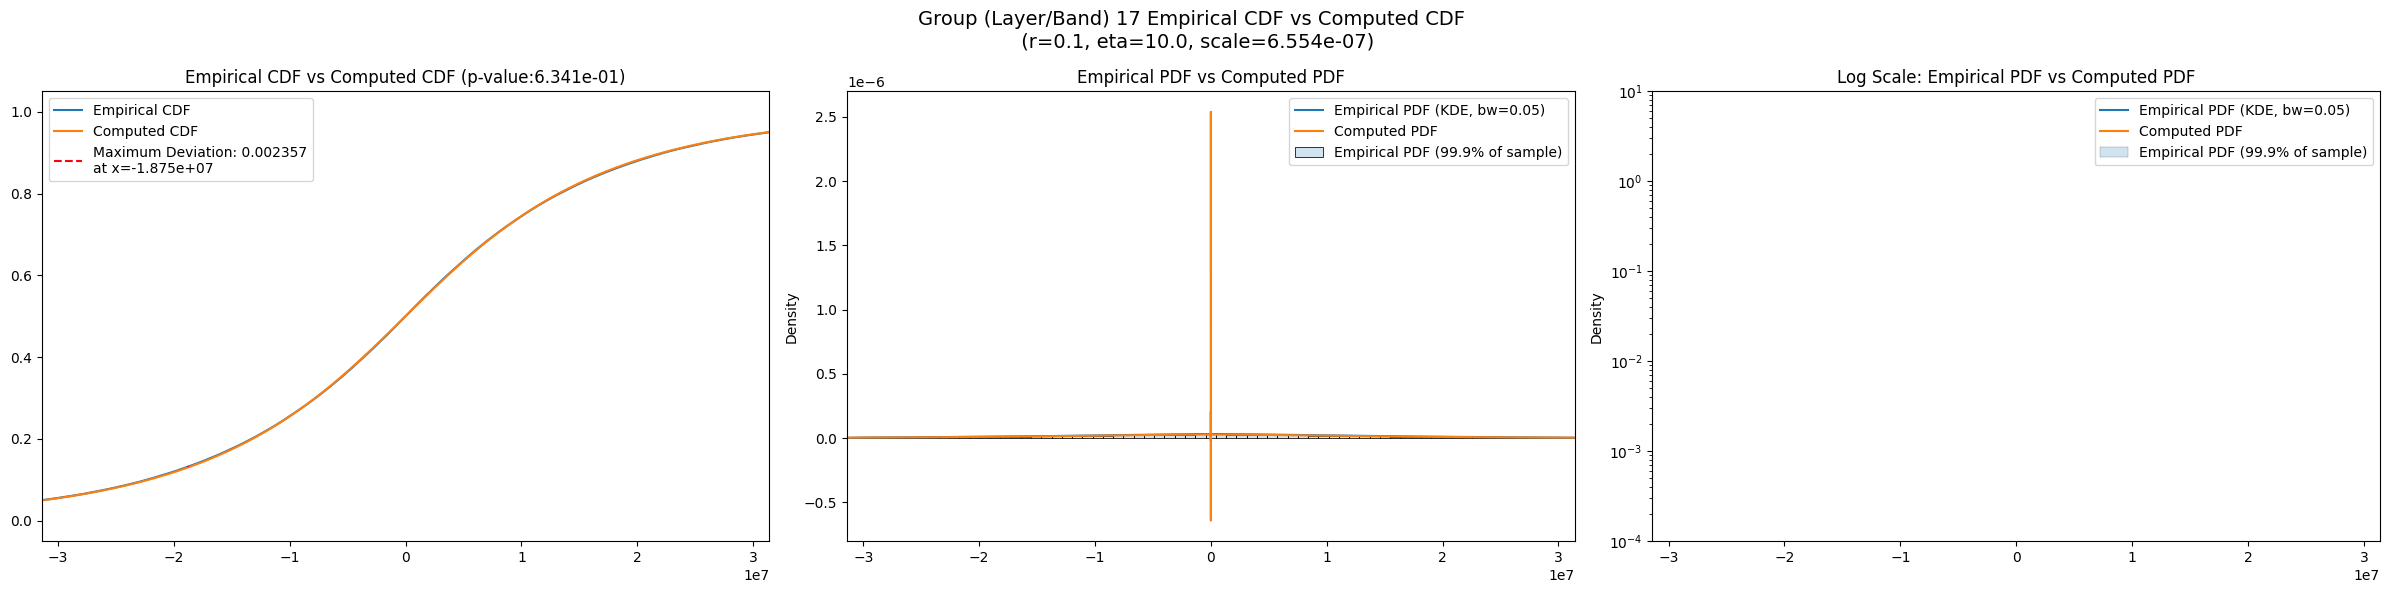

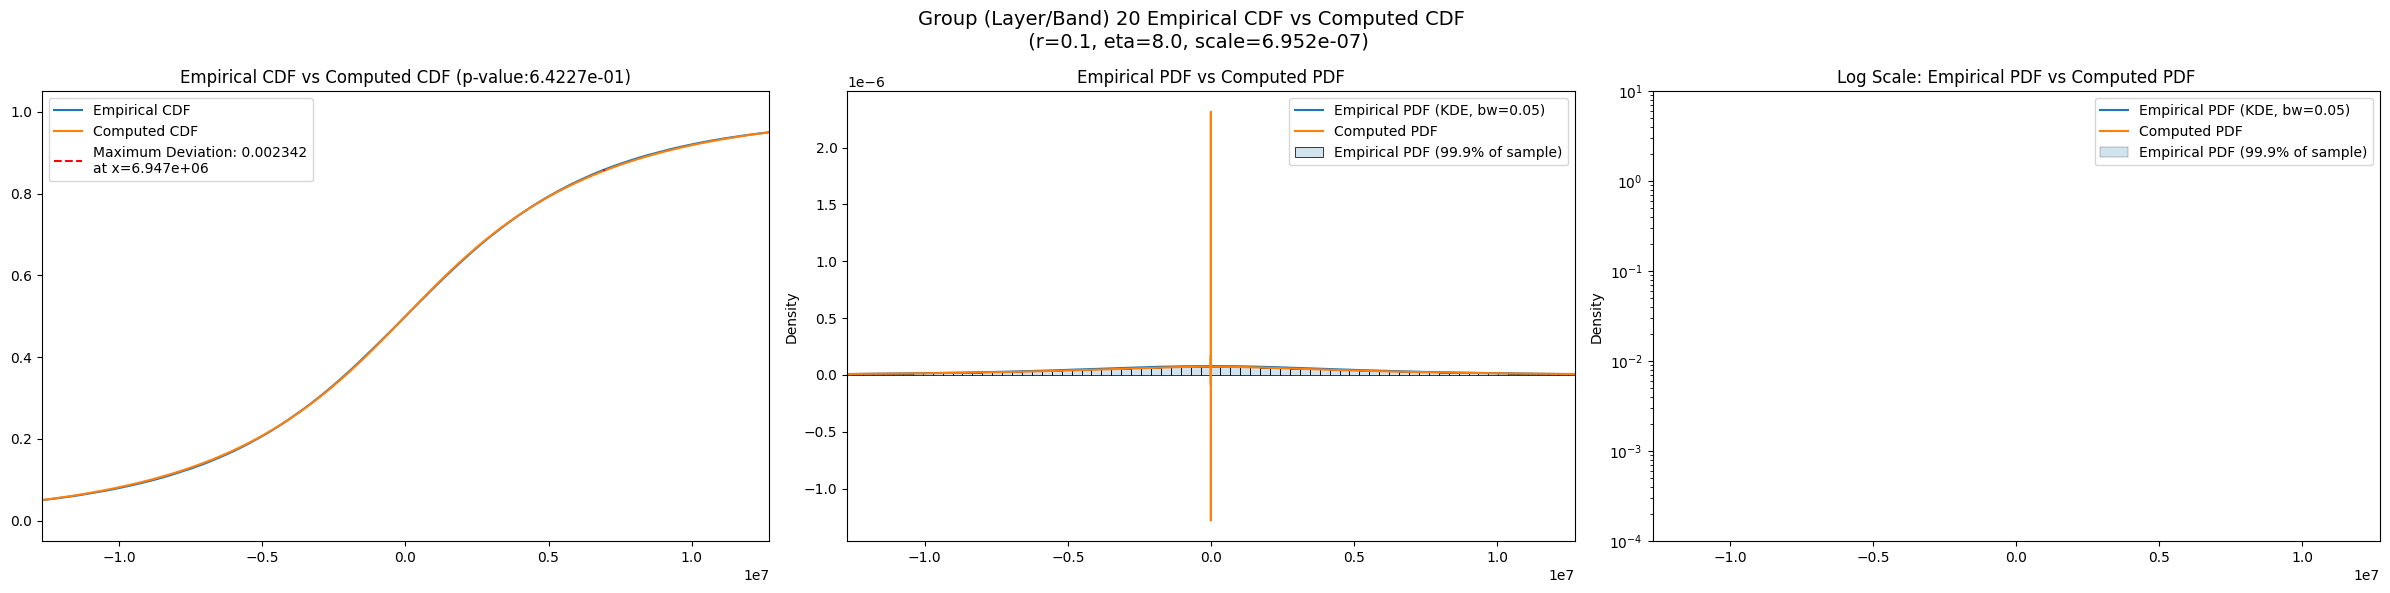

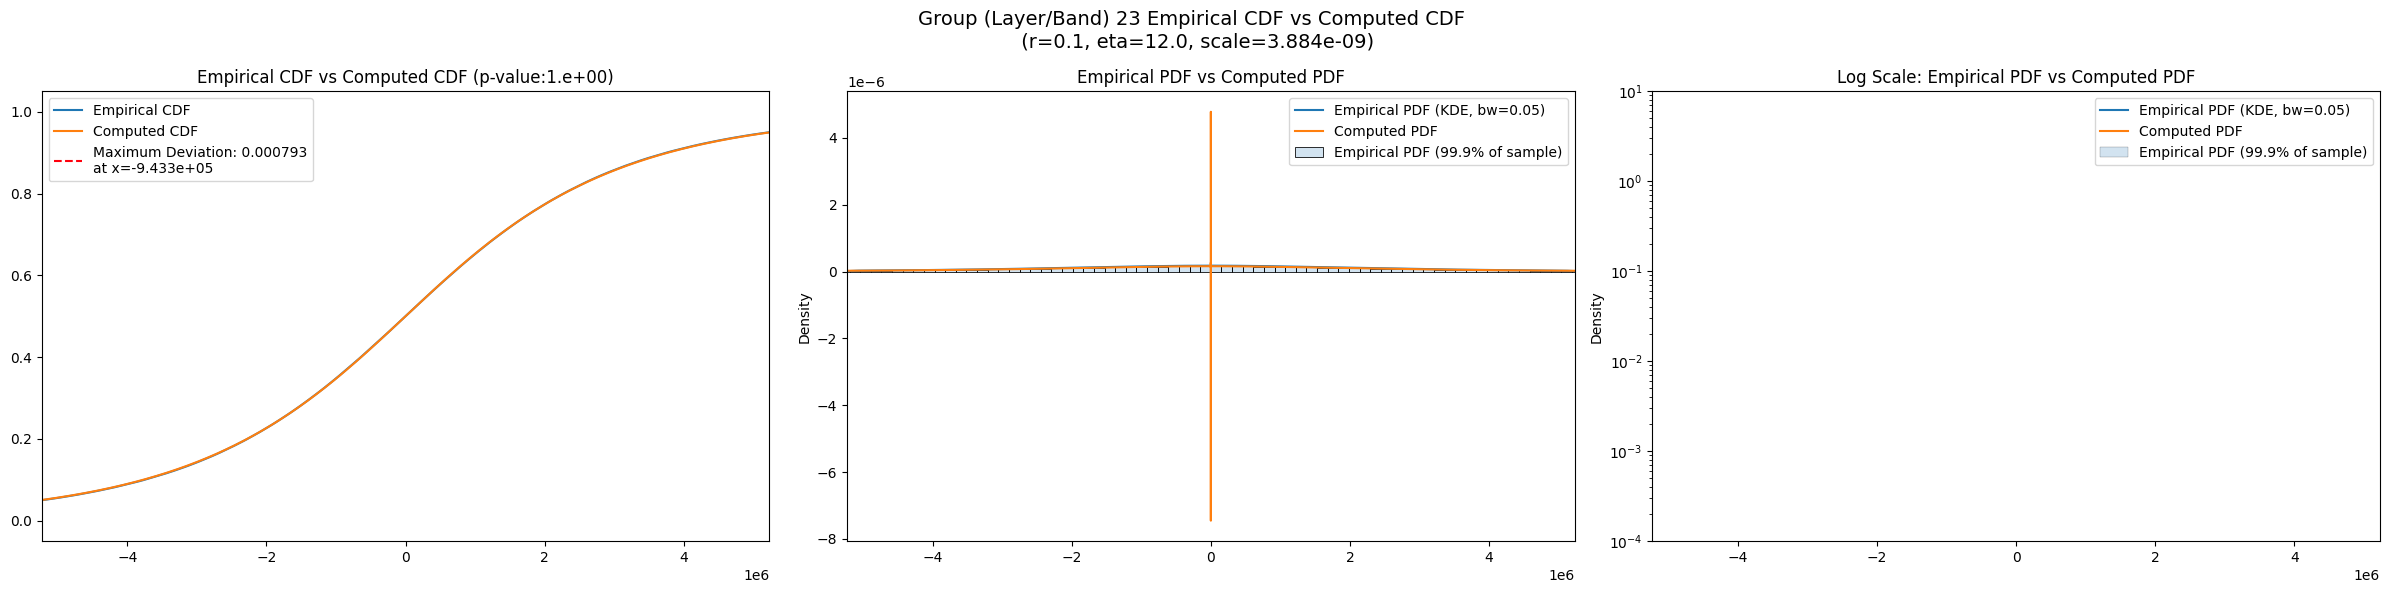

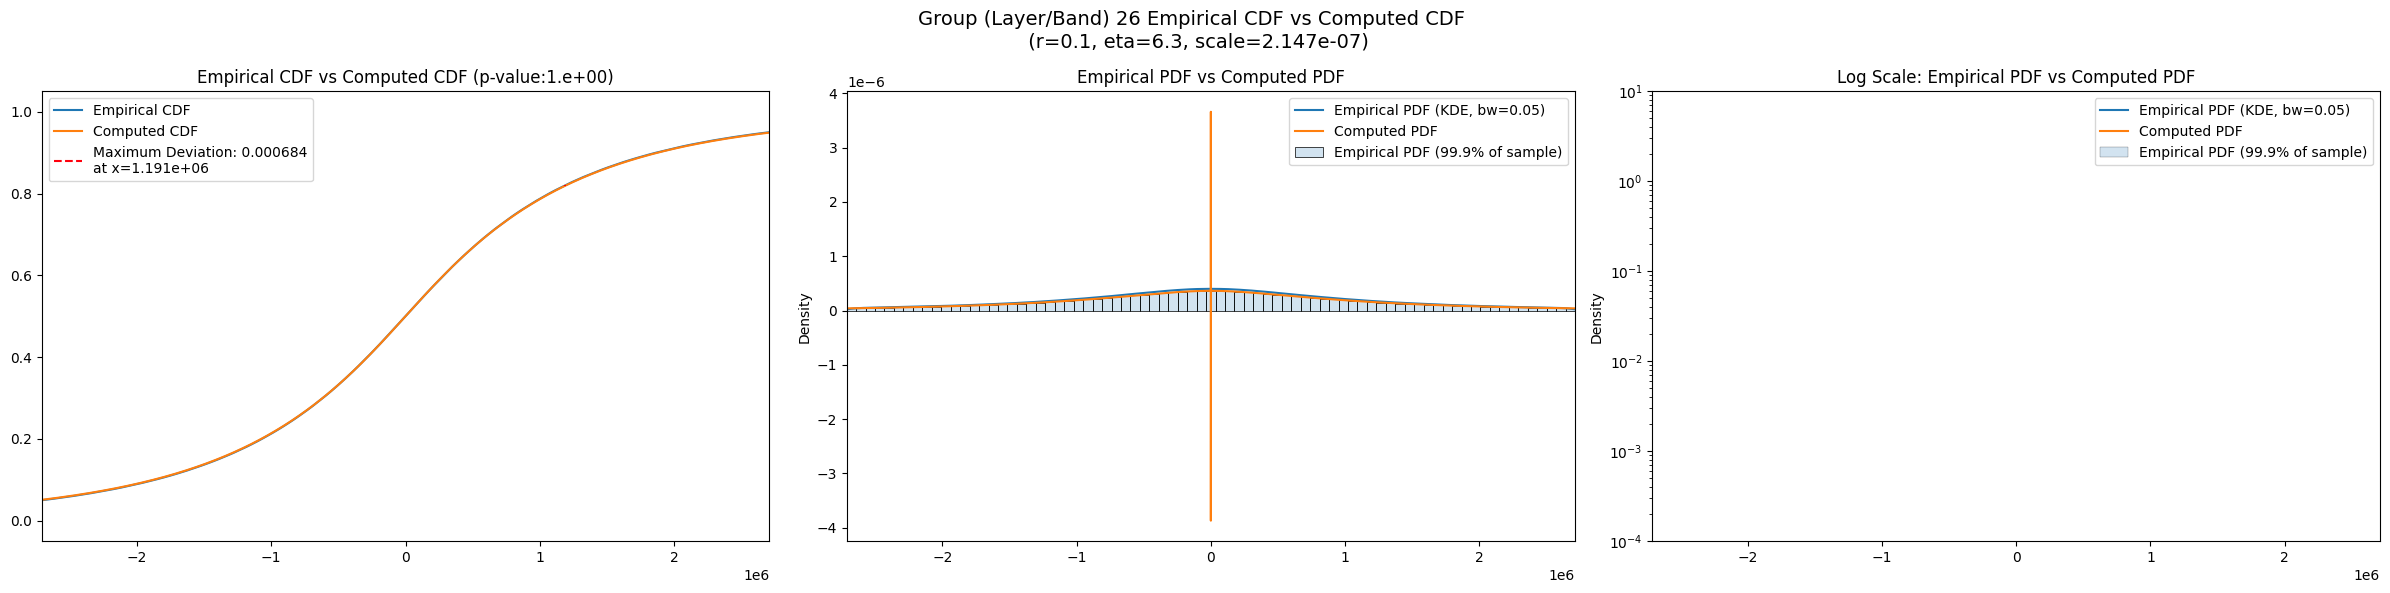

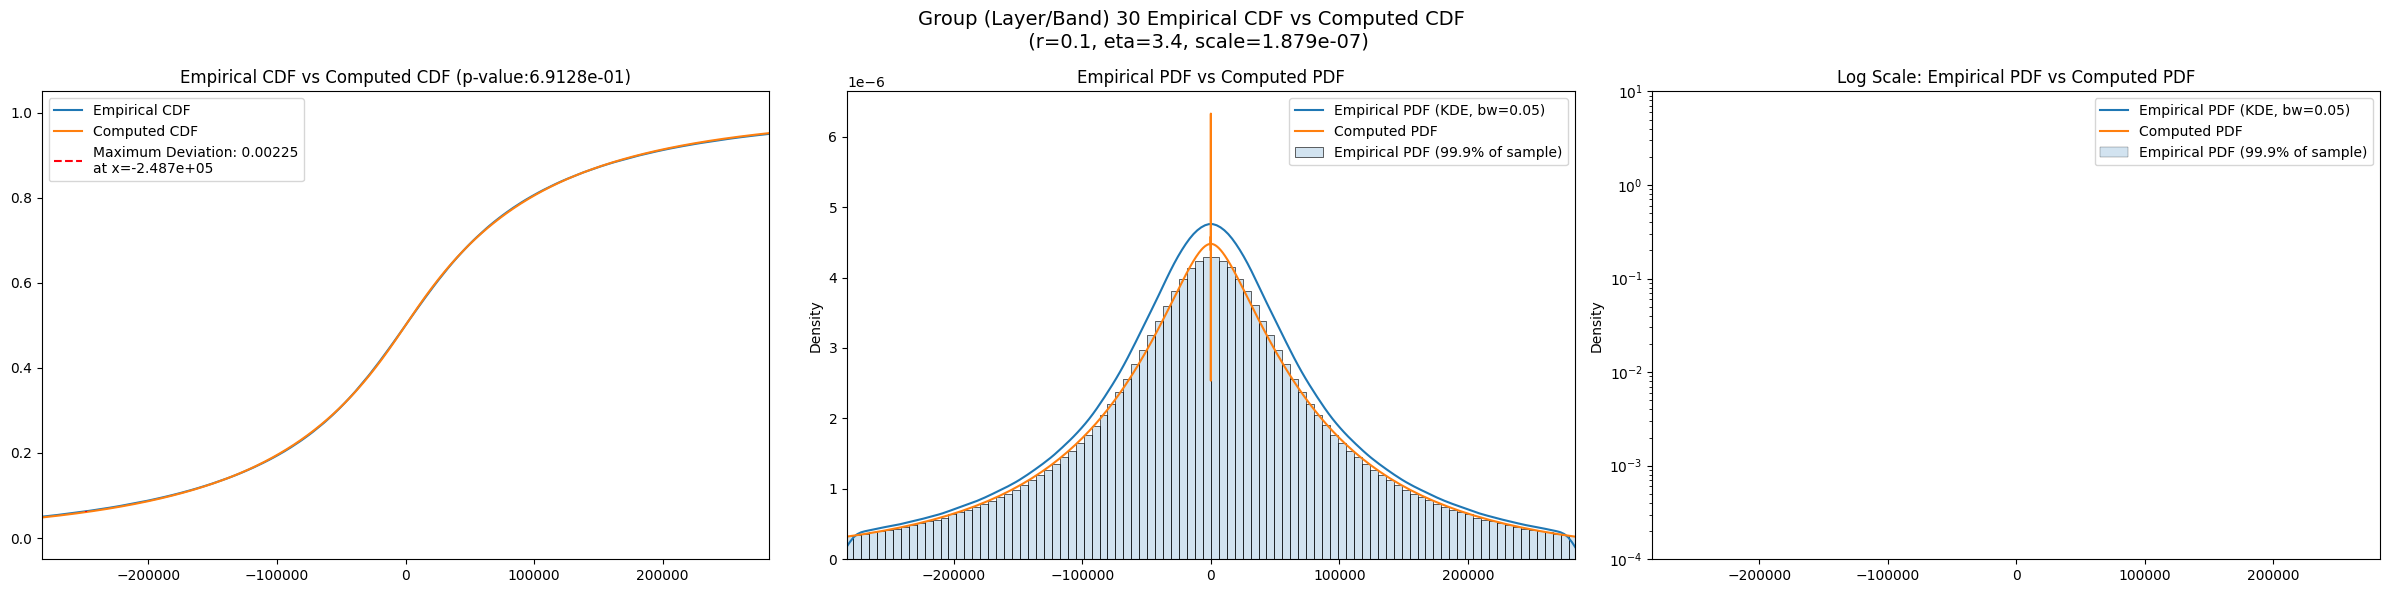

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     3.915643e+14  3.399509e+14  4.511006e+14   6.855218    3.785940   
5     9.777844e+14  8.494562e+14  1.116713e+15  22.652589   19.289485   
8     1.993210e+14  1.706700e+14  2.311273e+14  32.618782   23.913988   
11    1.418906e+13  1.165386e+13  1.851461e+13  86.686594   15.054620   
14    4.093398e+14  3.743596e+14  4.474916e+14  10.058353    7.365085   
17    3.880596e+14  3.658089e+14  4.122176e+14   3.375878    2.267853   
20    7.340230e+13  6.713867e+13  8.168032e+13  11.953053    5.117451   
23    1.111327e+13  1.043654e+13  1.189928e+13   4.444135    2.452249   
26    3.116548e+12  2.887243e+12  3.380704e+12   7.258533    4.206287   
30    3.558762e+10  3.261025e+10  3.898284e+10   9.742558    6.116816   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       9.952542         1440.0             0.013166        0.1          9.1   
5      26.255725         4320.0             0.014196        0.1          3.4   
8      41.579806        12240.0             0.011818        0.1          5.6   
11    257.973300        33840.0             0.003703        0.2          8.8   
14     14.099301        93600.0             0.019083        0.1          1.3   
17      6.326154       100000.0             0.002357        0.1         10.0   
20     40.137968       100000.0             0.002342        0.1          8.0   
23     12.334988       100000.0             0.000793        0.1         12.0   
26     17.534173       100000.0             0.000684        0.1          6.3   
30     21.662332       100000.0             0.002250        0.1          3.4   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.435872         2.360240e-249   
5     ...       1000000.0              0.410055          0.000000e+00   
8     ...       1000000.0              0.353280          0.000000e+00   
11    ...       1000000.0              0.222348          0.000000e+00   
14    ...       1000000.0              0.337661          0.000000e+00   
17    ...       1000000.0              0.424385          0.000000e+00   
20    ...       1000000.0              0.341174          0.000000e+00   
23    ...       1000000.0              0.215919          0.000000e+00   
26    ...       1000000.0              0.071197          0.000000e+00   
30    ...        127018.0              0.038266         1.163600e-127   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.397375        1.319850e-205  1000000.0   
5         1000000.0             0.374574         0.000000e+00  1000000.0   
8         1000000.0             0.308337         0.000000e+00  1000000.0   
11        1000000.0             0.178242         0.000000e+00  1000000.0   
14        1000000.0             0.295866         0.000000e+00  1000000.0   
17        1000000.0             0.390923         0.000000e+00  1000000.0   
20        1000000.0             0.296070         0.000000e+00  1000000.0   
23        1000000.0             0.171633         0.000000e+00  1000000.0   
26        1000000.0             0.030253         5.985230e-80   968913.0   
30         111247.0             0.011877         1.107750e-12    90626.4   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.374329  1.113140e-181          9.613814e-01  
5          0.351156   0.000000e+00          3.455386e-01  
8          0.284288   0.000000e+00          7.957826e-02  
11         0.153206   0.000000e+00          7.407348e-01  
14         0.272001   0.00000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.013166                 0.035671          0.013166   
5                0.014196                 0.020624          0.014196   
8                0.011818                 0.012262          0.011463   
11               0.003703                 0.007378          0.003703   
14               0.019083                 0.004437          0.019083   
17               0.002357                 0.004293          0.002357   
20               0.002342                 0.004293          0.002342   
23               0.000793                 0.004293          0.000793   
26               0.000684                 0.004293          0.000684   
30               0.002250                 0.004293          0.002250   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.435872             0.397375       0.374329  
5                 0.410055             0.374574       0.351156  
8                 0.353280             0.308337       0.284288  
11                0.222348             0.178242       0.153206  
14                0.337661             0.295866       0.272001  
17                0.424385             0.390923       0.368069  
20                0.341174             0.296070       0.272014  
23                0.215919             0.171633       0.146666  
26                0.071197             0.030253       0.008029  
30                0.038266             0.011877       0.009746

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           3.915643e+14          0.013166     0.1       9.1  1.447599e-06   
5           4.369172e+14          0.014196     0.1       3.4  2.307472e-03   
8           9.337122e+13          0.011463     0.1       5.2  2.695640e-05   
11          9.688535e+12          0.003703     0.2       8.8  2.214360e+04   
14          4.093398e+14          0.019083     0.1       1.3  3.238395e-01   
17          3.880596e+14          0.002357     0.1      10.0  6.553518e-07   
20          6.584325e+13          0.002342     0.1       8.0  6.951704e-07   
23          1.081684e+13          0.000793     0.1      12.0  3.884001e-09   
26          3.116548e+12          0.000684     0.1       6.3  2.146689e-07   
30          3.558762e+10          0.002250     0.1       3.4  1.879473e-07   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    75.0  
8                   175.0  
11                  150.0  
14                    0.0  
17                    0.0  
20                  100.0  
23                   25.0  
26                    0.0  
30                    0.0